In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'figure.figsize': (8, 6)
})

In [2]:
# Read in the full dataset
etf_data = pd.read_csv('Data/etf_data_cleaned.csv')
print("Shape of the data: ", etf_data.shape)
etf_data.head(10)

Shape of the data:  (988, 1505)


,isin,wkn,name,fundProvider,legalStructure,quote,ter,fundCurrency,inceptionDate,ticker,...,Russia,Investments,30,Change,Indonesia,Frontier,Vietnam,Momentum,A_1,Tech_label
0,IE00BMTX2B82,A2P9XA,iShares AEX UCITS ETF EUR (Acc),iShares,ETF,6.68,0.0030,EUR,2020-07-29,AYE7,...,0,0,0,0,0,0,0,0,0.0,0.0
1,NL0009272749,A1JN2C,VanEck AEX UCITS ETF,VanEck,ETF,72.34,0.0030,EUR,2009-12-14,2TCA,...,0,0,0,0,0,0,0,0,0.0,0.0
2,IE00BKPTXQ89,A2P4PH,HANetf Alerian Midstream Energy Dividend UCITS...,HANetf,ETF,10.70,0.0040,USD,2020-07-27,JMLP,...,0,0,0,0,0,0,0,0,0.0,0.0
3,NL0009272756,A1JPFU,VanEck AMX UCITS ETF,VanEck,ETF,92.64,0.0035,EUR,2009-12-14,2TCE,...,0,0,0,0,0,0,0,0,0.0,0.0
4,DE000A0D8Q23,A0D8Q2,iShares ATX UCITS ETF (DE),iShares,ETF,34.38,0.0032,EUR,2005-08-04,EXXX,...,0,0,0,0,0,0,0,0,0.0,0.0
5,LU0659579063,DBX0KJ,Xtrackers ATX UCITS ETF 1C,Xtrackers,ETF,58.14,0.0025,EUR,2011-11-11,XB4A,...,0,0,0,0,0,0,0,0,0.0,0.0
6,GB00BLD4ZL17,A3GPMN,CoinShares Physical Bitcoin,CoinShares,ETN,25.35,0.0098,USD,2021-01-19,BITC,...,0,0,0,0,0,0,0,0,0.0,0.0
7,DE000A28M8D0,A28M8D,VanEck Bitcoin ETN,VanEck,ETN,14.11,0.0100,USD,2020-11-19,VBTC,...,0,0,0,0,0,0,0,0,0.0,0.0
8,CH0475552201,A2126N,21Shares Bitcoin Cash ETP,21Shares,ETN,5.37,0.0250,USD,2019-07-04,ABCH,...,0,0,0,0,0,0,0,0,0.0,0.0
9,IE00BKPSFD61,A2P3WK,iShares China CNY Bond UCITS ETF USD (Acc),iShares,ETF,5.24,0.0035,USD,2020-05-14,AYER,...,0,0,0,0,0,0,0,0,0.0,0.0


## Part 1: Labelling

### Defining Tresholds

### Distribution of avg_monthly_return, volatility, and RSI

Below we plot the distribution of `avg_monthly_return`, `volatility`, and `RSI` for all observations in the dataset.

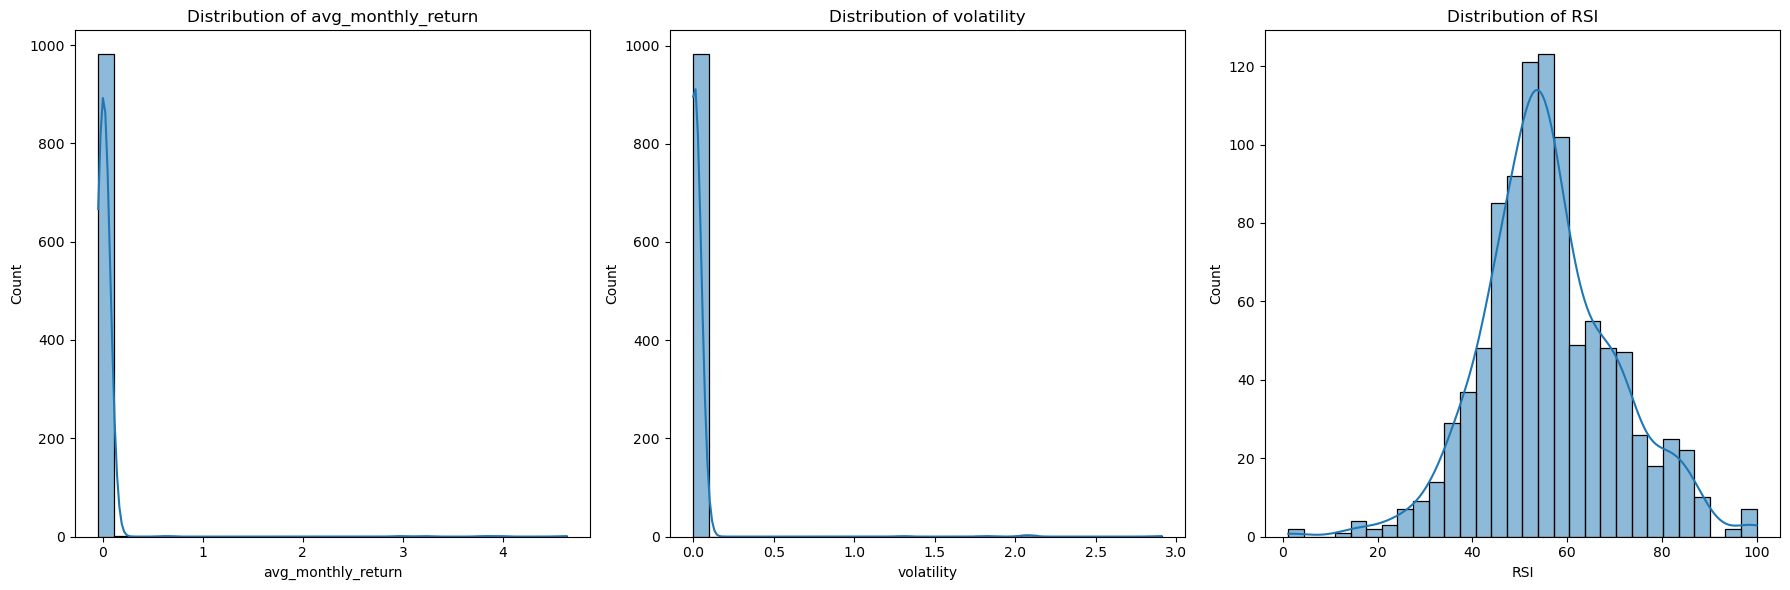

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(etf_data['avg_monthly_return'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of avg_monthly_return')

sns.histplot(etf_data['volatility'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of volatility')

sns.histplot(etf_data['RSI'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Distribution of RSI')

plt.tight_layout()
plt.show()

In [4]:
median_values = etf_data[['avg_monthly_return', 'volatility', 'RSI']].median()
print(median_values)

avg_monthly_return     0.006170
volatility             0.009797
RSI                   54.602387
dtype: float64


### Remove Outliers

In [5]:
# Calculate the 5th and 95th percentiles for avg_monthly_return and volatility
percentiles = etf_data[['avg_monthly_return', 'volatility']].quantile([0.05, 0.95])

# Filter the data to remove observations outside the 5th and 95th percentiles
filtered_data = etf_data[
    (etf_data['avg_monthly_return'] >= percentiles.loc[0.05, 'avg_monthly_return']) &
    (etf_data['avg_monthly_return'] <= percentiles.loc[0.95, 'avg_monthly_return']) &
    (etf_data['volatility'] >= percentiles.loc[0.05, 'volatility']) &
    (etf_data['volatility'] <= percentiles.loc[0.95, 'volatility'])
]

print("Shape of the filtered data: ", filtered_data.shape)
filtered_data.head(10)

Shape of the filtered data:  (821, 1505)


,isin,wkn,name,fundProvider,legalStructure,quote,ter,fundCurrency,inceptionDate,ticker,...,Russia,Investments,30,Change,Indonesia,Frontier,Vietnam,Momentum,A_1,Tech_label
0,IE00BMTX2B82,A2P9XA,iShares AEX UCITS ETF EUR (Acc),iShares,ETF,6.68,0.0030,EUR,2020-07-29,AYE7,...,0,0,0,0,0,0,0,0,0.0,0.0
1,NL0009272749,A1JN2C,VanEck AEX UCITS ETF,VanEck,ETF,72.34,0.0030,EUR,2009-12-14,2TCA,...,0,0,0,0,0,0,0,0,0.0,0.0
3,NL0009272756,A1JPFU,VanEck AMX UCITS ETF,VanEck,ETF,92.64,0.0035,EUR,2009-12-14,2TCE,...,0,0,0,0,0,0,0,0,0.0,0.0
4,DE000A0D8Q23,A0D8Q2,iShares ATX UCITS ETF (DE),iShares,ETF,34.38,0.0032,EUR,2005-08-04,EXXX,...,0,0,0,0,0,0,0,0,0.0,0.0
5,LU0659579063,DBX0KJ,Xtrackers ATX UCITS ETF 1C,Xtrackers,ETF,58.14,0.0025,EUR,2011-11-11,XB4A,...,0,0,0,0,0,0,0,0,0.0,0.0
9,IE00BKPSFD61,A2P3WK,iShares China CNY Bond UCITS ETF USD (Acc),iShares,ETF,5.24,0.0035,USD,2020-05-14,AYER,...,0,0,0,0,0,0,0,0,0.0,0.0
12,IE00BDFL4P12,A2DK6R,iShares Diversified Commodity Swap UCITS ETF,iShares,ETF,6.11,0.0019,USD,2017-07-18,SXRS,...,0,0,0,0,0,0,0,0,0.0,0.0
13,DE000A0H0728,A0H072,iShares Diversified Commodity Swap UCITS ETF (DE),iShares,ETF,24.53,0.0046,EUR,2007-08-07,EXXY,...,0,0,0,0,0,0,0,0,0.0,0.0
14,IE00BF0BCP69,A2DQ7M,L&G All Commodities UCITS ETF,Legal & General (LGIM),ETF,12.30,0.0015,USD,2017-07-11,ETLF,...,0,0,0,0,0,0,0,0,0.0,0.0
15,IE00BKY4W127,A2QSKH,WisdomTree Broad Commodities UCITS ETF,WisdomTree,ETF,9.83,0.0019,USD,2021-11-29,PCOM,...,0,0,0,0,0,0,0,0,0.0,0.0


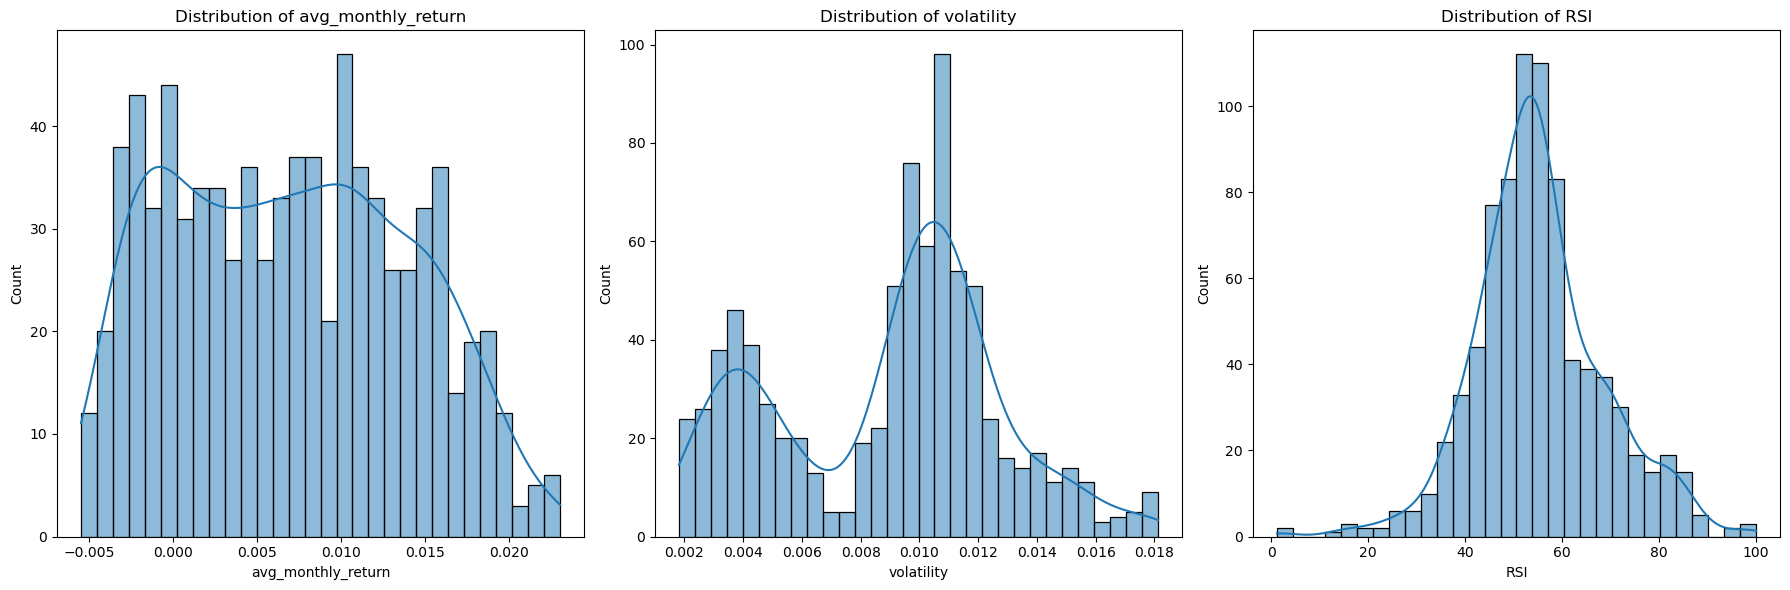

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(filtered_data['avg_monthly_return'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of avg_monthly_return')

sns.histplot(filtered_data['volatility'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of volatility')

sns.histplot(filtered_data['RSI'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Distribution of RSI')

plt.tight_layout()
plt.show()

In [7]:
median_values = filtered_data[['avg_monthly_return', 'volatility', 'RSI']].median()
print(median_values)

avg_monthly_return     0.006874
volatility             0.009795
RSI                   53.970173
dtype: float64


In [8]:
# Add 'return_class' column
filtered_data['return_class'] = np.where(filtered_data['avg_monthly_return'] > median_values['avg_monthly_return'], 'high', 'low')

# Add 'volatility_class' column
filtered_data['volatility_class'] = np.where(filtered_data['volatility'] > median_values['volatility'], 'high', 'low')

# Add 'growth_potential' column
conditions = [
    (filtered_data['RSI'] > 70),
    (filtered_data['RSI'] < 30)
]
choices = ['low', 'high']
filtered_data['growth_potential'] = np.select(conditions, choices, default='undefined')

filtered_data.head(10)

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/2469562399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['return_class'] = np.where(filtered_data['avg_monthly_return'] > median_values['avg_monthly_return'], 'high', 'low')
/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/2469562399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['volatility_class'] = np.where(filtered_data['volatility'] > median_values['volatility'], 'high', 'low')
/var/f

,isin,wkn,name,fundProvider,legalStructure,quote,ter,fundCurrency,inceptionDate,ticker,...,Change,Indonesia,Frontier,Vietnam,Momentum,A_1,Tech_label,return_class,volatility_class,growth_potential
0,IE00BMTX2B82,A2P9XA,iShares AEX UCITS ETF EUR (Acc),iShares,ETF,6.68,0.0030,EUR,2020-07-29,AYE7,...,0,0,0,0,0,0.0,0.0,high,high,undefined
1,NL0009272749,A1JN2C,VanEck AEX UCITS ETF,VanEck,ETF,72.34,0.0030,EUR,2009-12-14,2TCA,...,0,0,0,0,0,0.0,0.0,high,high,undefined
3,NL0009272756,A1JPFU,VanEck AMX UCITS ETF,VanEck,ETF,92.64,0.0035,EUR,2009-12-14,2TCE,...,0,0,0,0,0,0.0,0.0,low,high,undefined
4,DE000A0D8Q23,A0D8Q2,iShares ATX UCITS ETF (DE),iShares,ETF,34.38,0.0032,EUR,2005-08-04,EXXX,...,0,0,0,0,0,0.0,0.0,high,high,undefined
5,LU0659579063,DBX0KJ,Xtrackers ATX UCITS ETF 1C,Xtrackers,ETF,58.14,0.0025,EUR,2011-11-11,XB4A,...,0,0,0,0,0,0.0,0.0,high,high,undefined
9,IE00BKPSFD61,A2P3WK,iShares China CNY Bond UCITS ETF USD (Acc),iShares,ETF,5.24,0.0035,USD,2020-05-14,AYER,...,0,0,0,0,0,0.0,0.0,low,low,undefined
12,IE00BDFL4P12,A2DK6R,iShares Diversified Commodity Swap UCITS ETF,iShares,ETF,6.11,0.0019,USD,2017-07-18,SXRS,...,0,0,0,0,0,0.0,0.0,high,high,undefined
13,DE000A0H0728,A0H072,iShares Diversified Commodity Swap UCITS ETF (DE),iShares,ETF,24.53,0.0046,EUR,2007-08-07,EXXY,...,0,0,0,0,0,0.0,0.0,high,high,undefined
14,IE00BF0BCP69,A2DQ7M,L&G All Commodities UCITS ETF,Legal & General (LGIM),ETF,12.30,0.0015,USD,2017-07-11,ETLF,...,0,0,0,0,0,0.0,0.0,high,high,undefined
15,IE00BKY4W127,A2QSKH,WisdomTree Broad Commodities UCITS ETF,WisdomTree,ETF,9.83,0.0019,USD,2021-11-29,PCOM,...,0,0,0,0,0,0.0,0.0,low,low,undefined


/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/1708863723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['return_class'] = pd.Categorical(filtered_data['return_class'], categories=['low', 'high'], ordered=True)
/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/1708863723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['volatility_class'] = pd.Categorical(filtered_data['volatility_class'], categories=['low', 'high'], ordered=True)
/var/fol

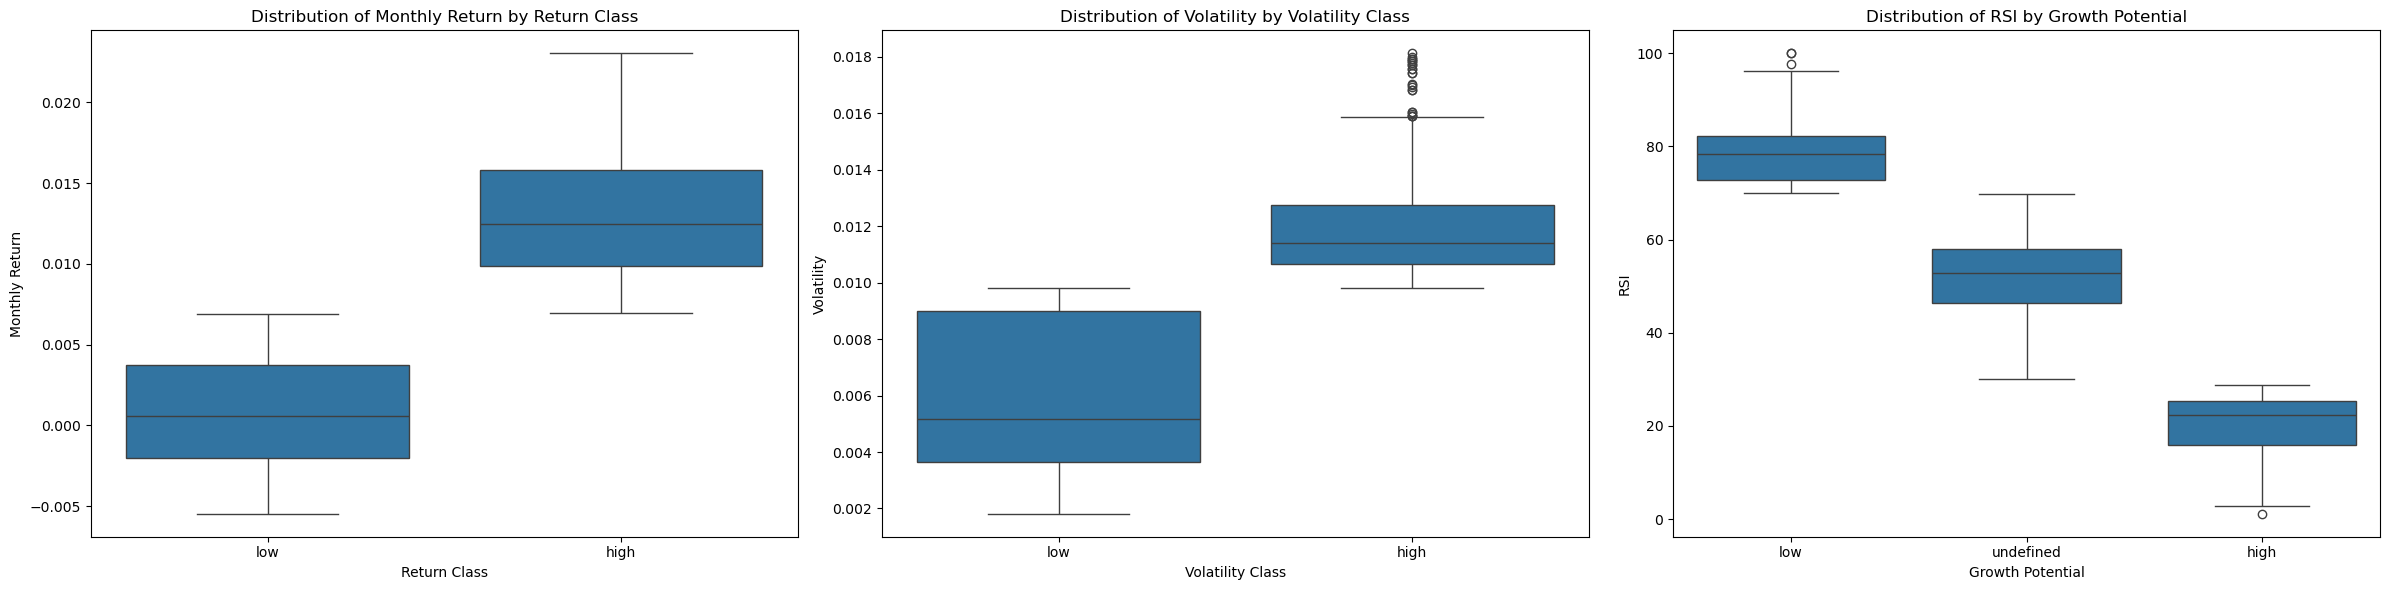

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
filtered_data['return_class'] = pd.Categorical(filtered_data['return_class'], categories=['low', 'high'], ordered=True)
filtered_data['volatility_class'] = pd.Categorical(filtered_data['volatility_class'], categories=['low', 'high'], ordered=True)

# Plot distribution of avg_monthly_return by return class
sns.boxplot(x='return_class', y='avg_monthly_return', data=filtered_data, ax=axes[0])
axes[0].set_title('Distribution of Monthly Return by Return Class')
axes[0].set_xlabel('Return Class')
axes[0].set_ylabel('Monthly Return')

# Plot distribution of volatility by volatility class
sns.boxplot(x='volatility_class', y='volatility', data=filtered_data, ax=axes[1])
axes[1].set_title('Distribution of Volatility by Volatility Class')
axes[1].set_xlabel('Volatility Class')
axes[1].set_ylabel('Volatility')

# Plot distribution of RSI by growth potential in order low, undefined, high
filtered_data['growth_potential'] = pd.Categorical(filtered_data['growth_potential'], categories=['low', 'undefined', 'high'], ordered=True)
sns.boxplot(x='growth_potential', y='RSI', data=filtered_data, ax=axes[2])
axes[2].set_title('Distribution of RSI by Growth Potential')
axes[2].set_xlabel('Growth Potential')
axes[2].set_ylabel('RSI')

plt.tight_layout()
plt.show()

### One-hot Encoding

In [10]:
categorical_columns = filtered_data.select_dtypes(include=['category']).columns
print("Categorical columns:", categorical_columns)
object_columns = filtered_data.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)

Categorical columns: Index(['return_class', 'volatility_class', 'growth_potential'], dtype='object')
Object columns: Index(['isin', 'wkn', 'name', 'fundProvider', 'legalStructure', 'fundCurrency',
       'inceptionDate', 'ticker', 'domicileCountry'],
      dtype='object')


In [11]:
# Drop uninformative columns
drop_columns = [
    'isin',
    'wkn',
    'name',
    'ticker',
    'inceptionDate',
    'legalStructure',
    'domicileCountry'
]

filtered_data = filtered_data.drop(columns=drop_columns)

In [12]:
object_columns = filtered_data.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)

Object columns: Index(['fundProvider', 'fundCurrency'], dtype='object')


In [13]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Select the columns to be one-hot encoded
columns_to_encode = ['fundProvider', 'fundCurrency']

# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_data[columns_to_encode])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Concatenate the encoded columns with the original DataFrame
filtered_data = pd.concat([filtered_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop the original columns that were encoded
filtered_data = filtered_data.drop(columns=columns_to_encode)

filtered_data.head()

,quote,ter,maxAge,cashPosition,stockPosition,bondPosition,otherPosition,preferredPosition,convertiblePosition,priceToEarnings,...,fundProvider_iShares,fundCurrency_CHF,fundCurrency_CHF Hedged,fundCurrency_EUR,fundCurrency_EUR Hedged,fundCurrency_GBP,fundCurrency_GBP Hedged,fundCurrency_JPY,fundCurrency_USD,fundCurrency_USD Hedged
0,6.68,0.0030,1,0.0042,0.9957,0.0,0.0,0.0,0.0,0.06184,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72.34,0.0030,1,0.0026,0.9974,0.0,0.0,0.0,0.0,0.06185,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,92.64,0.0035,1,-0.0288,1.0288,0.0,0.0,0.0,0.0,0.06283,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34.38,0.0032,1,0.0356,0.9644,0.0,0.0,0.0,0.0,0.11598,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58.14,0.0025,1,0.0210,0.9790,0.0,0.0,0.0,0.0,0.11598,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
categorical_columns = ['return_class', 'volatility_class', 'growth_potential']

# Move categorical columns to the end
filtered_data = filtered_data[[col for col in filtered_data.columns if col not in categorical_columns] + list(categorical_columns)]
filtered_data.head()

,quote,ter,maxAge,cashPosition,stockPosition,bondPosition,otherPosition,preferredPosition,convertiblePosition,priceToEarnings,...,fundCurrency_EUR,fundCurrency_EUR Hedged,fundCurrency_GBP,fundCurrency_GBP Hedged,fundCurrency_JPY,fundCurrency_USD,fundCurrency_USD Hedged,return_class,volatility_class,growth_potential
0,6.68,0.0030,1,0.0042,0.9957,0.0,0.0,0.0,0.0,0.06184,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,undefined
1,72.34,0.0030,1,0.0026,0.9974,0.0,0.0,0.0,0.0,0.06185,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,undefined
2,92.64,0.0035,1,-0.0288,1.0288,0.0,0.0,0.0,0.0,0.06283,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,low,high,undefined
3,34.38,0.0032,1,0.0356,0.9644,0.0,0.0,0.0,0.0,0.11598,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,undefined
4,58.14,0.0025,1,0.0210,0.9790,0.0,0.0,0.0,0.0,0.11598,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,high,high,undefined


### Train-Test Split

In [15]:
financial_metrics_columns = ['avg_monthly_return',
                              'volatility', 
                              'RSI',
                              'Var',
                              'drawdown',
                              'avg_sharpe_ratio',
                              'beta',
                              'priceToEarnings',
                              'priceToBook',
                              'priceToSales',
                              'priceToCashflow'
                              ]

In [16]:
# Define the features and target variable
X = filtered_data.drop(columns=categorical_columns)
y = filtered_data[categorical_columns]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (574, 1531)
Shape of X_test: (247, 1531)
Shape of y_train: (574, 3)
Shape of y_test: (247, 3)


In [17]:
# Extract the financial metrics from X_train and X_test
X_train_financial_metrics = X_train[financial_metrics_columns]
X_test_financial_metrics = X_test[financial_metrics_columns]

# Drop the financial metrics from X_train and X_test
X_train = X_train.drop(columns=financial_metrics_columns)
X_test = X_test.drop(columns=financial_metrics_columns)

# Display the shape of the extracted financial metrics and the modified X_train and X_test
print("X_train financial metrics:\n", X_train_financial_metrics.shape)
print("X_test financial metrics:\n", X_test_financial_metrics.shape)
print("Modified X_train:\n", X_train.shape)
print("Modified X_test:\n", X_test.shape)

X_train financial metrics:
 (574, 11)
X_test financial metrics:
 (247, 11)
Modified X_train:
 (574, 1520)
Modified X_test:
 (247, 1520)


In [18]:
y_train_return = y_train.loc[:,'return_class']
y_train_volatility = y_train.loc[:,'volatility_class']
y_train_growth = y_train.loc[:,'growth_potential']

y_test_return = y_test.loc[:,'return_class']
y_test_volatility = y_test.loc[:,'volatility_class']
y_test_growth = y_test.loc[:,'growth_potential']

In [19]:
y_train_return.head()

234    high
220    high
457     low
329     low
132     low
Name: return_class, dtype: category
Categories (2, object): ['low' < 'high']

## Predict Returns

In [20]:
y_train_return = y_train_return.map({'high': 1, 'low': 0})
y_test_return = y_test_return.map({'high': 1, 'low': 0})

In [21]:
num_nan_y_train_return = y_train_return.isna().sum()
print("Number of NaN in y_train_return:", num_nan_y_train_return)

Number of NaN in y_train_return: 0


### Logistic Regression

Accuracy: 0.8826
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       125
           1       0.85      0.93      0.89       122

    accuracy                           0.88       247
   macro avg       0.89      0.88      0.88       247
weighted avg       0.89      0.88      0.88       247



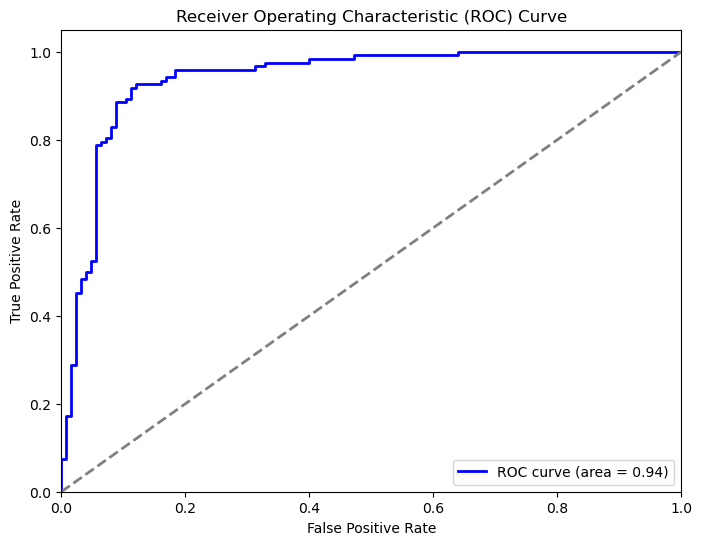

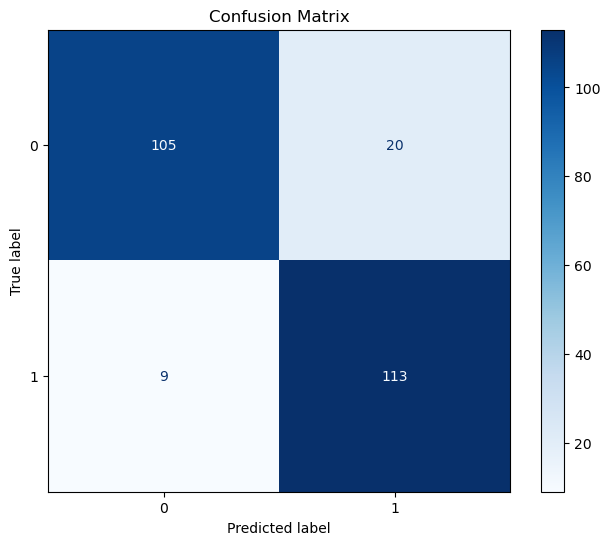

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to the training data
logistic_model.fit(X_train, y_train_return)

# Predict the return class for the test data
y_pred_return = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_return, y_pred_return)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test_return, y_pred_return))
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test_return.cat.codes, logistic_model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test_return.cat.codes, logistic_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix

cm = confusion_matrix(y_test_return, y_pred_return)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/206696263.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df, order=order, palette=['green', 'red', 'green', 'red'])


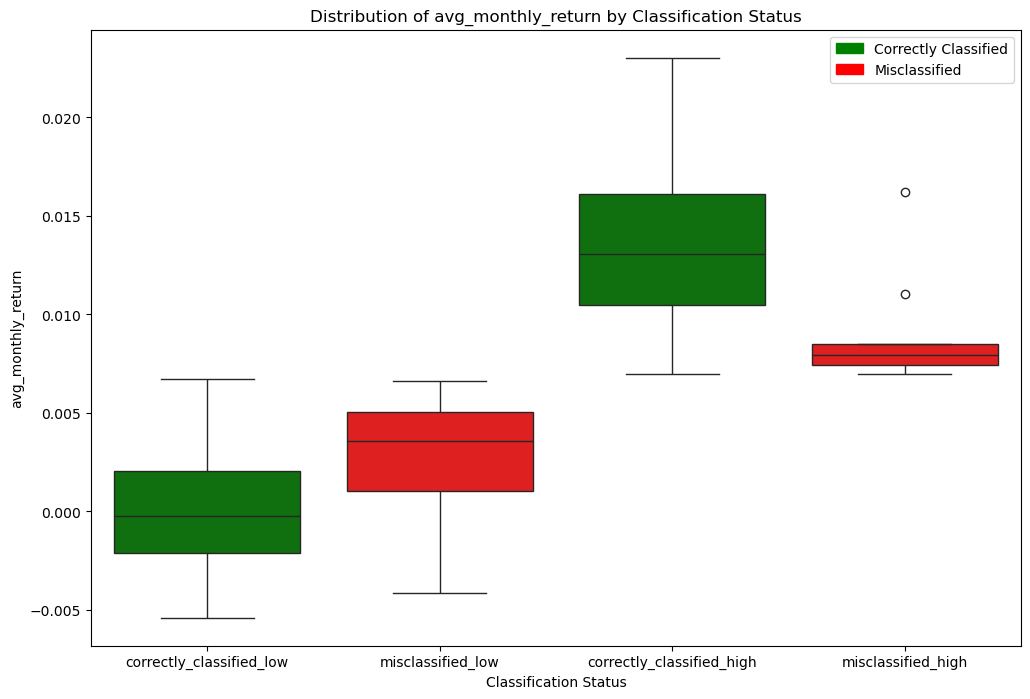

In [23]:
import matplotlib.patches as mpatches

# Add true labels and predicted labels to results_df
results_df = X_test_financial_metrics.copy()
results_df['true_label'] = y_test_return.values
results_df['predicted_label'] = y_pred_return

# Create a new column to indicate whether the classification was correct
results_df['correctly_classified'] = results_df['true_label'] == results_df['predicted_label']

# Create a new column to indicate the classification status
results_df['classification_status'] = results_df.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df, order=order, palette=['green', 'red', 'green', 'red'])
plt.title('Distribution of avg_monthly_return by Classification Status')
plt.xlabel('Classification Status')
plt.ylabel('avg_monthly_return')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch], loc='upper right')

plt.show()

### CART

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2}
Accuracy: 0.7976
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       125
           1       0.80      0.79      0.79       122

    accuracy                           0.80       247
   macro avg       0.80      0.80      0.80       247
weighted avg       0.80      0.80      0.80       247



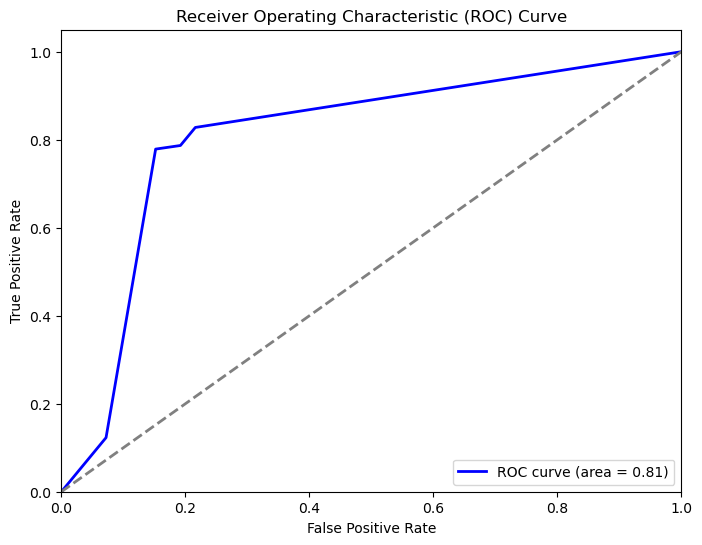

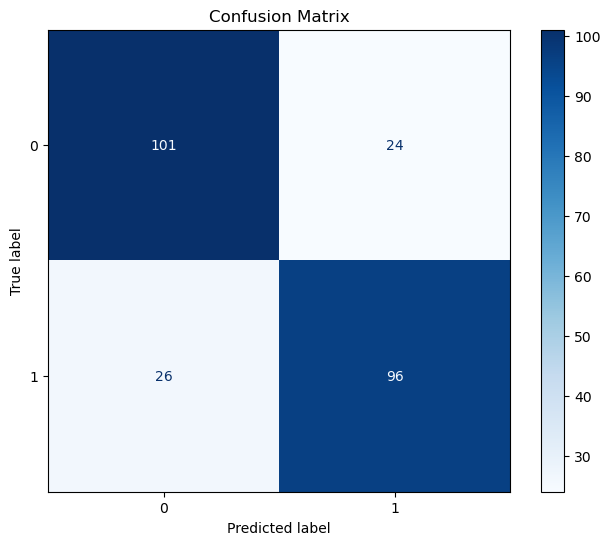

In [24]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Define the parameter grid
param_grid = {
    'max_depth': range(5, 101, 5),
    'min_samples_leaf': range(1, 21, 1)
}

# Initialize the DecisionTreeClassifier
cart_model = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(cart_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train_return)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Fit the model with the best parameters
best_cart_model = grid_search.best_estimator_

# Predict the return class for the test data
y_pred_cart_return = best_cart_model.predict(X_test)

# Evaluate the model
accuracy_cart = accuracy_score(y_test_return, y_pred_cart_return)
print(f"Accuracy: {accuracy_cart:.4f}")
print("Classification Report:")
print(classification_report(y_test_return, y_pred_cart_return))

# Plot the ROC curve
fpr_cart, tpr_cart, _ = roc_curve(y_test_return.cat.codes, best_cart_model.predict_proba(X_test)[:, 1])
roc_auc_cart = roc_auc_score(y_test_return.cat.codes, best_cart_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_cart, tpr_cart, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_cart:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
cm_cart = confusion_matrix(y_test_return, y_pred_cart_return)
disp_cart = ConfusionMatrixDisplay(confusion_matrix=cm_cart, display_labels=best_cart_model.classes_)
disp_cart.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

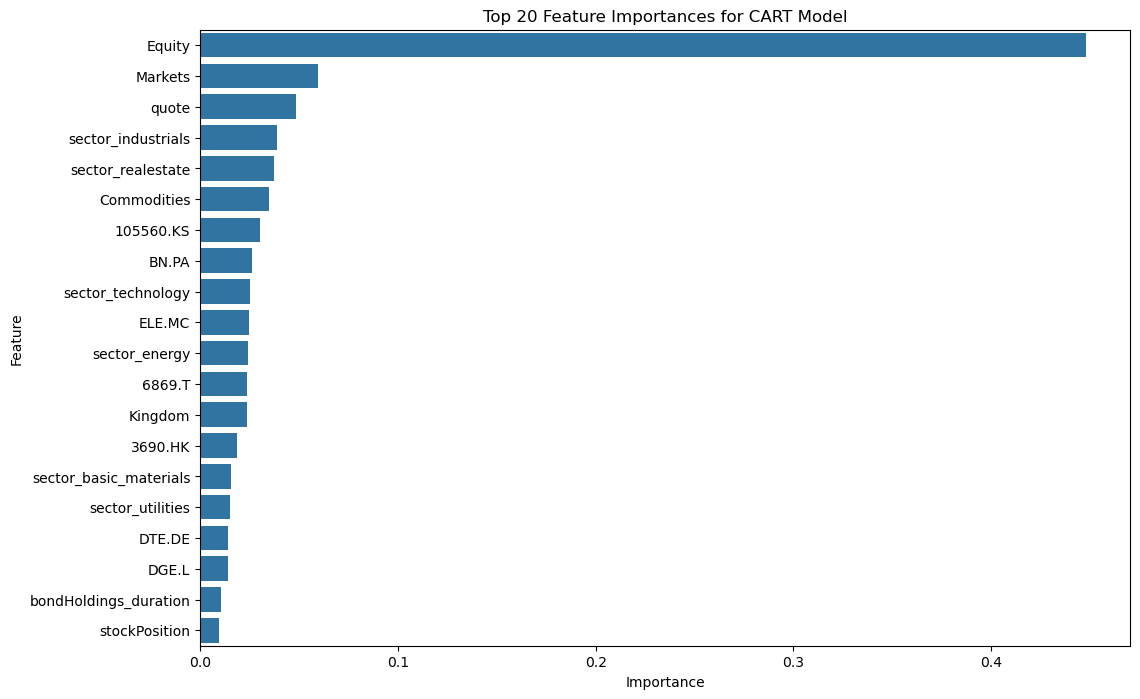

In [25]:
# Get feature importances from the best CART model
importances = best_cart_model.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances for CART Model')
plt.show()

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/661214853.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df_cart, order=order, palette=['green', 'red', 'green', 'red'])


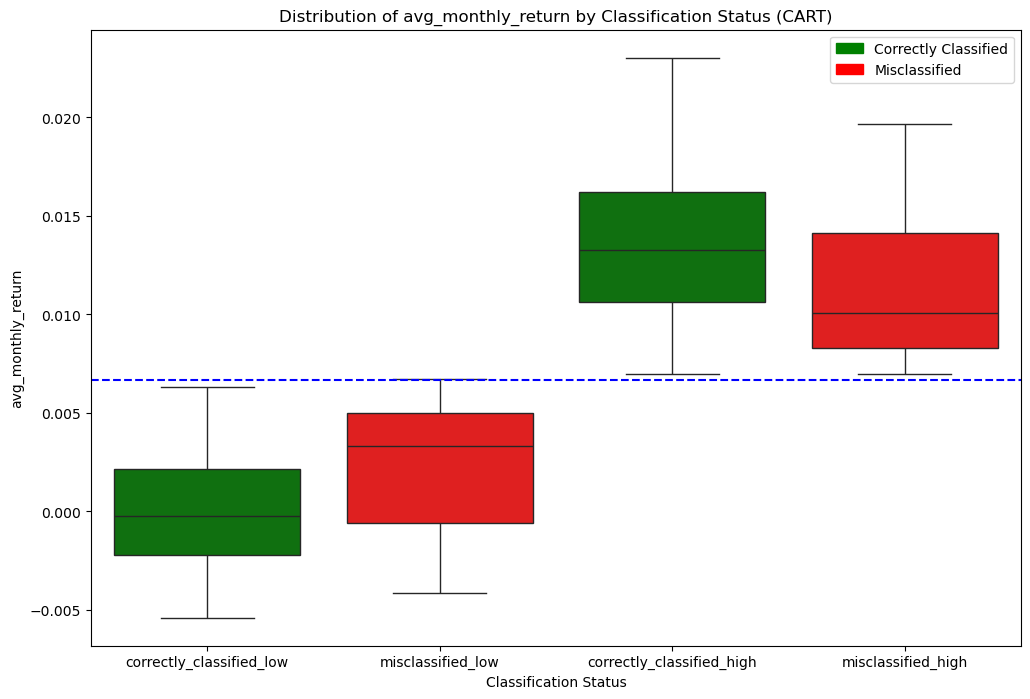

In [26]:
# Add true labels and predicted labels to results_df for CART model
# Calculate the average monthly return for the test set
avg_monthly_return_test = X_test_financial_metrics['avg_monthly_return'].mean()

# Add true labels and predicted labels to results_df for CART model
results_df_cart = X_test_financial_metrics.copy()
results_df_cart['true_label'] = y_test_return.values
results_df_cart['predicted_label'] = y_pred_cart_return

# Create a new column to indicate whether the classification was correct
results_df_cart['correctly_classified'] = results_df_cart['true_label'] == results_df_cart['predicted_label']

# Create a new column to indicate the classification status
results_df_cart['classification_status'] = results_df_cart.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot for CART model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df_cart, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_monthly_return_test, color='blue', linestyle='--', label='Average Monthly Return (Test Set)')
plt.title('Distribution of avg_monthly_return by Classification Status (CART)')
plt.xlabel('Classification Status')
plt.ylabel('avg_monthly_return')
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Monthly Return (Test Set)')], loc='upper right')
# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch], loc='upper right')

plt.show()

### Random Forest

Best parameters for Random Forest: {'max_depth': 30, 'n_estimators': 100}
Accuracy of Random Forest: 0.8826
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       125
           1       0.83      0.95      0.89       122

    accuracy                           0.88       247
   macro avg       0.89      0.88      0.88       247
weighted avg       0.89      0.88      0.88       247



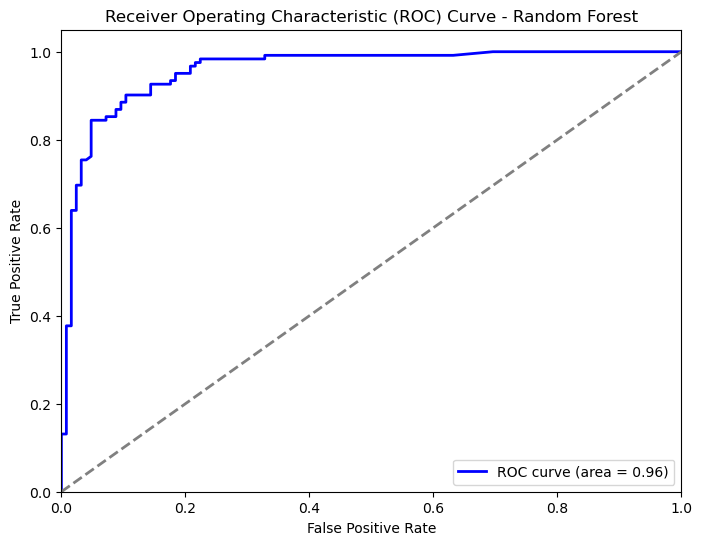

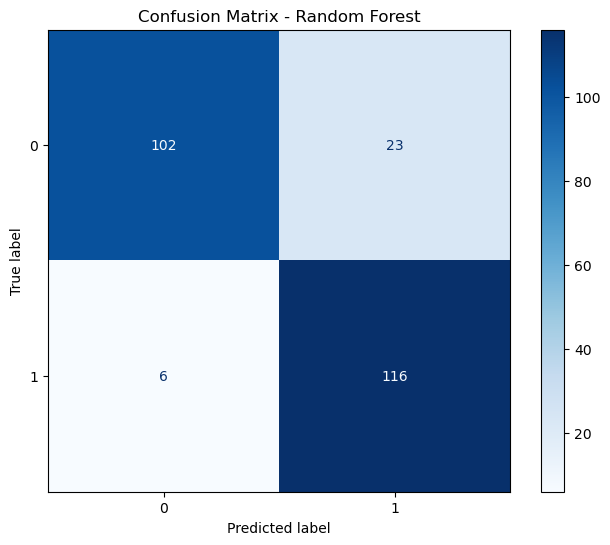

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': range(10, 101, 5),
    'max_depth': range(10, 101, 10)
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train_return)

# Get the best parameters for Random Forest
best_params_rf = grid_search_rf.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Fit the Random Forest model with the best parameters
best_rf_model = grid_search_rf.best_estimator_

# Predict the return class for the test data using Random Forest
y_pred_rf_return = best_rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test_return, y_pred_rf_return)
print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")
print("Classification Report for Random Forest:")
print(classification_report(y_test_return, y_pred_rf_return))

# Plot the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_return.cat.codes, best_rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test_return.cat.codes, best_rf_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test_return, y_pred_rf_return)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf_model.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

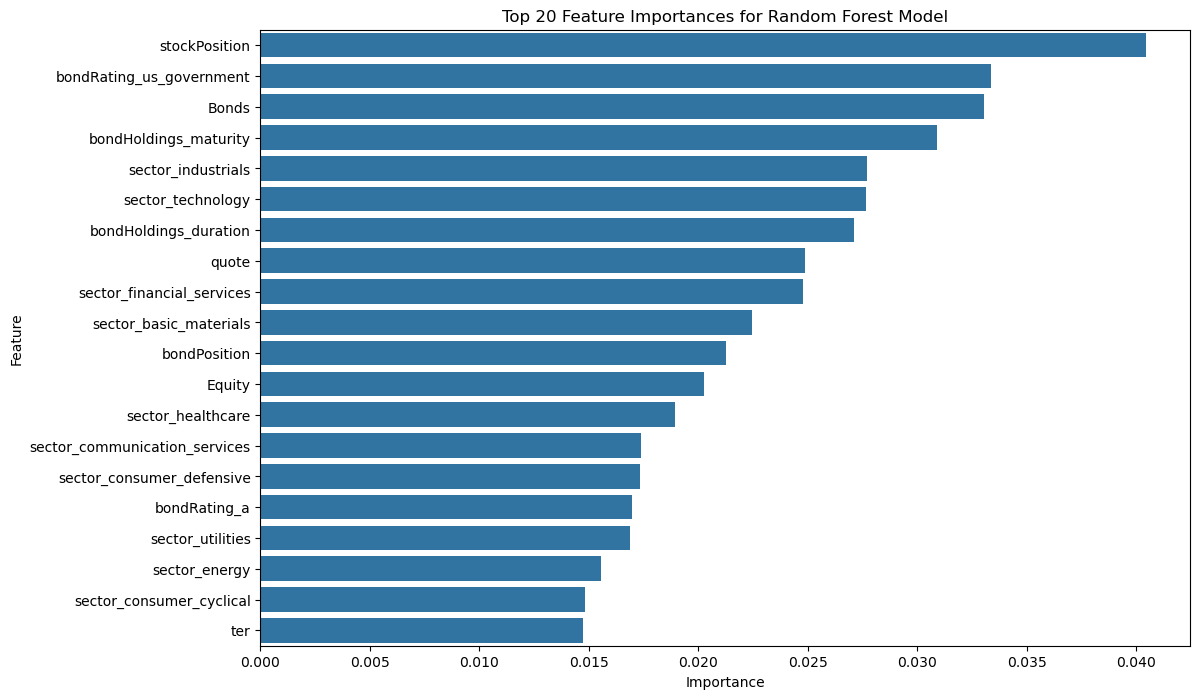

In [28]:
# Get feature importances from the best Random Forest model
importances_rf = best_rf_model.feature_importances_

# Get the feature names
feature_names_rf = X_train.columns

# Create a DataFrame for better visualization
feature_importances_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances_rf})

# Sort the DataFrame by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(20))
plt.title('Top 20 Feature Importances for Random Forest Model')
plt.show()

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/739401316.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df_rf, order=order, palette=['green', 'red', 'green', 'red'])


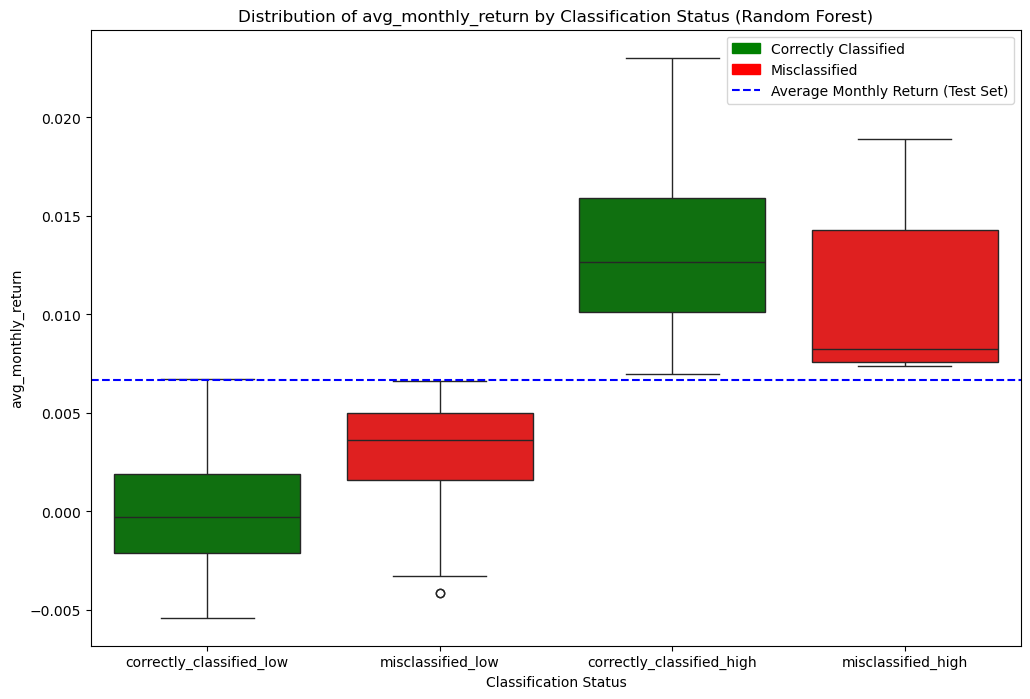

In [29]:
# Add true labels and predicted labels to results_df for Random Forest model
results_df_rf = X_test_financial_metrics.copy()
results_df_rf['true_label'] = y_test_return.values
results_df_rf['predicted_label'] = y_pred_rf_return

# Create a new column to indicate whether the classification was correct
results_df_rf['correctly_classified'] = results_df_rf['true_label'] == results_df_rf['predicted_label']

# Create a new column to indicate the classification status
results_df_rf['classification_status'] = results_df_rf.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot for Random Forest model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df_rf, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_monthly_return_test, color='blue', linestyle='--', label='Average Monthly Return (Test Set)')
plt.title('Distribution of avg_monthly_return by Classification Status (Random Forest)')
plt.xlabel('Classification Status')
plt.ylabel('avg_monthly_return')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Monthly Return (Test Set)')], loc='upper right')

plt.show()

### XGBoost

/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parame

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
Accuracy of XGBoost: 0.8502
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       125
           1       0.81      0.90      0.86       122

    accuracy                           0.85       247
   macro avg       0.85      0.85      0.85       247
weighted avg       0.85      0.85      0.85       247



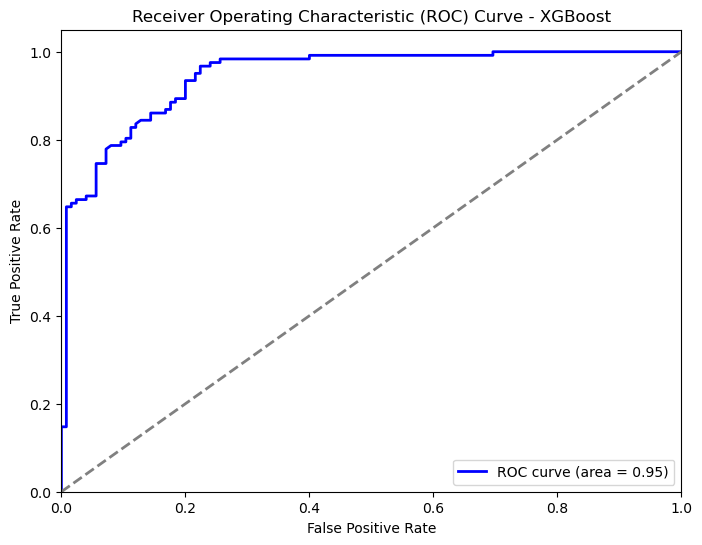

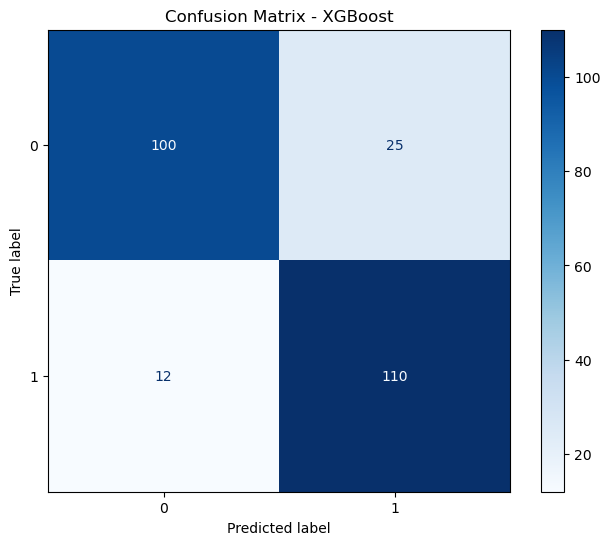

In [30]:
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': range(2, 6, 1),
    'n_estimators': range(5, 51, 5),
    'learning_rate': [1e-3, 1e-2, 1e-1, 1]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train_return)

# Get the best parameters for XGBoost
best_params_xgb = grid_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")

# Fit the XGBoost model with the best parameters
best_xgb_model = grid_search_xgb.best_estimator_

# Predict the return class for the test data using XGBoost
y_pred_xgb_return = best_xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test_return, y_pred_xgb_return)
print(f"Accuracy of XGBoost: {accuracy_xgb:.4f}")
print("Classification Report for XGBoost:")
print(classification_report(y_test_return, y_pred_xgb_return))

# Plot the ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_return.cat.codes, best_xgb_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test_return.cat.codes, best_xgb_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_return, y_pred_xgb_return)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=best_xgb_model.classes_)
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.show()

<Figure size 1200x800 with 0 Axes>

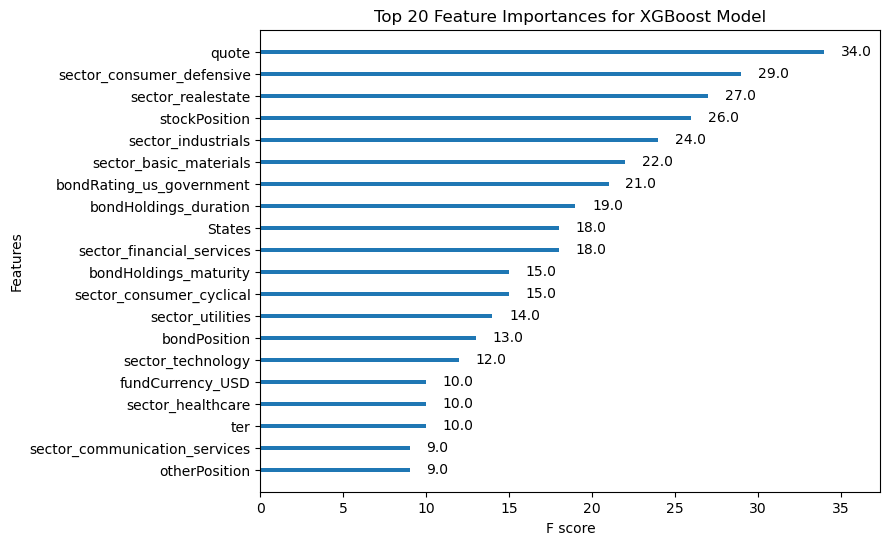

In [31]:
from xgboost import plot_importance

# Plot the feature importances
plt.figure(figsize=(12, 8))
plot_importance(best_xgb_model, max_num_features=20, importance_type='weight')
plt.grid(False)
plt.title('Top 20 Feature Importances for XGBoost Model')
plt.show()

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/1041151324.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df_xgb, order=order, palette=['green', 'red', 'green', 'red'])


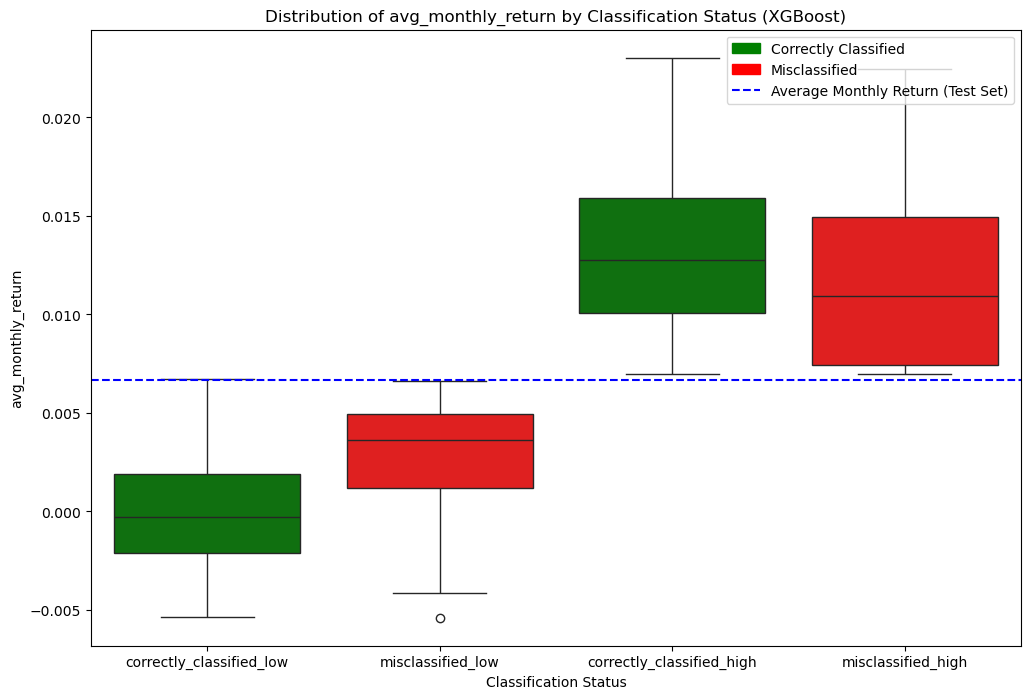

In [32]:
# Add true labels and predicted labels to results_df for XGBoost model
results_df_xgb = X_test_financial_metrics.copy()
results_df_xgb['true_label'] = y_test_return.values
results_df_xgb['predicted_label'] = y_pred_xgb_return

# Create a new column to indicate whether the classification was correct
results_df_xgb['correctly_classified'] = results_df_xgb['true_label'] == results_df_xgb['predicted_label']

# Create a new column to indicate the classification status
results_df_xgb['classification_status'] = results_df_xgb.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot for XGBoost model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='avg_monthly_return', data=results_df_xgb, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_monthly_return_test, color='blue', linestyle='--', label='Average Monthly Return (Test Set)')
plt.title('Distribution of avg_monthly_return by Classification Status (XGBoost)')
plt.xlabel('Classification Status')
plt.ylabel('avg_monthly_return')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Monthly Return (Test Set)')], loc='upper right')

plt.show()

### Model Comparison

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/3536336834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')


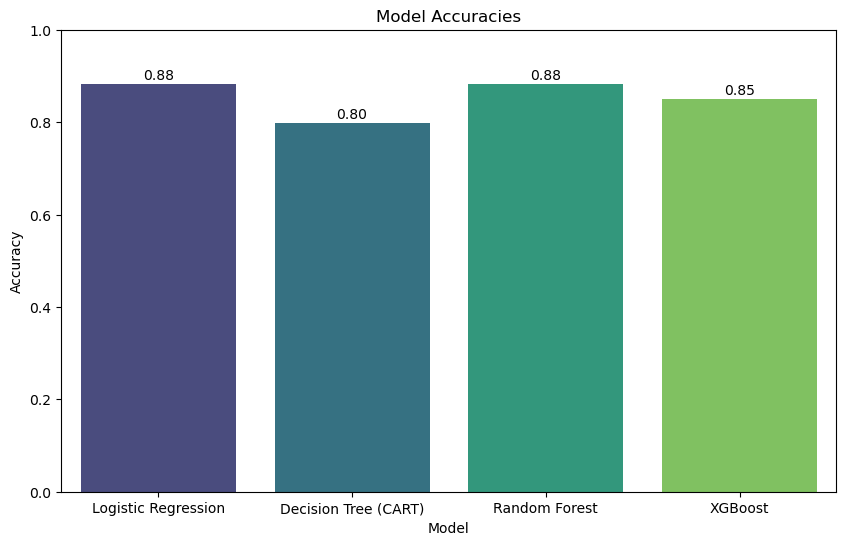

In [33]:
# Create a dictionary with model names and their accuracies
model_accuracies = {
    'Logistic Regression': accuracy,
    'Decision Tree (CART)': accuracy_cart,
    'Random Forest': accuracy_rf,
    'XGBoost': accuracy_xgb
}

# Create a DataFrame from the dictionary
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')

# Add the value of the accuracy on top of each bar
for index, row in accuracy_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", color='black', ha="center")

plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## Predicting Volatility

### Logistic Regression

In [34]:
# Map the volatility classes to binary values
y_train_volatility = y_train_volatility.map({'high': 1, 'low': 0})
y_test_volatility = y_test_volatility.map({'high': 1, 'low': 0})

Accuracy: 0.8704
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       112
           1       0.87      0.90      0.88       135

    accuracy                           0.87       247
   macro avg       0.87      0.87      0.87       247
weighted avg       0.87      0.87      0.87       247



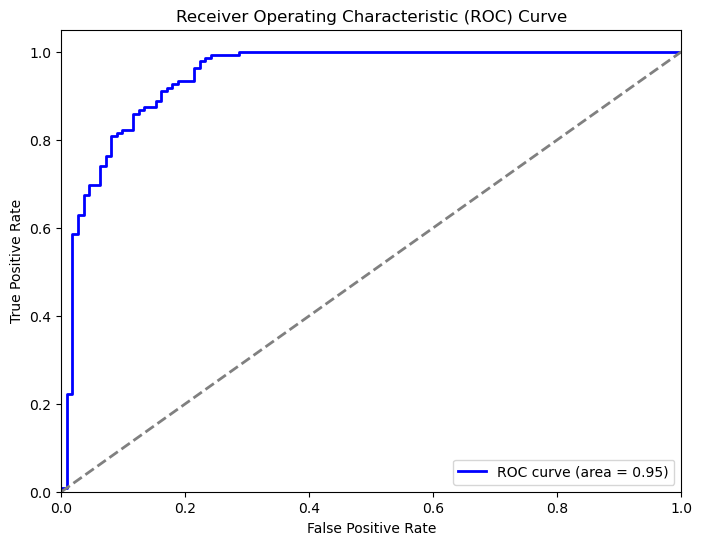

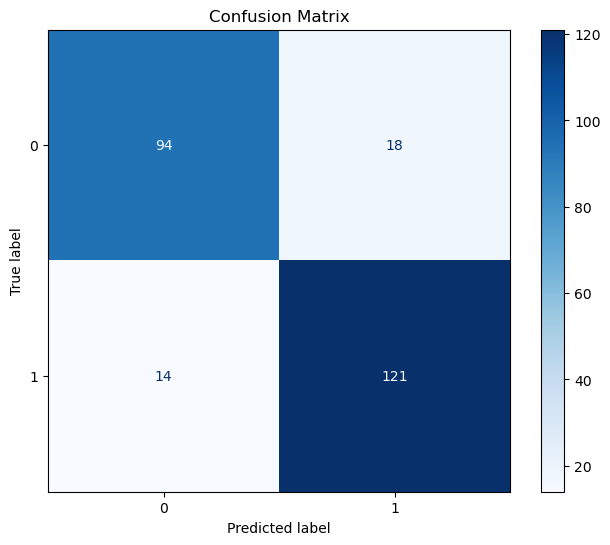

In [35]:
# Initialize the logistic regression model
logistic_model_volatility = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to the training data
logistic_model_volatility.fit(X_train, y_train_volatility)

# Predict the volatility class for the test data
y_pred_volatility = logistic_model_volatility.predict(X_test)

# Evaluate the model
accuracy_volatility = accuracy_score(y_test_volatility, y_pred_volatility)
print(f"Accuracy: {accuracy_volatility:.4f}")
print("Classification Report:")
print(classification_report(y_test_volatility, y_pred_volatility))

# Plot the ROC curve
fpr_volatility, tpr_volatility, _ = roc_curve(y_test_volatility.cat.codes, logistic_model_volatility.predict_proba(X_test)[:, 1])
roc_auc_volatility = roc_auc_score(y_test_volatility.cat.codes, logistic_model_volatility.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_volatility, tpr_volatility, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_volatility:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
cm_volatility = confusion_matrix(y_test_volatility, y_pred_volatility)
disp_volatility = ConfusionMatrixDisplay(confusion_matrix=cm_volatility, display_labels=logistic_model_volatility.classes_)
disp_volatility.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/2159107627.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='volatility', data=results_df_volatility, order=order, palette=['green', 'red', 'green', 'red'])


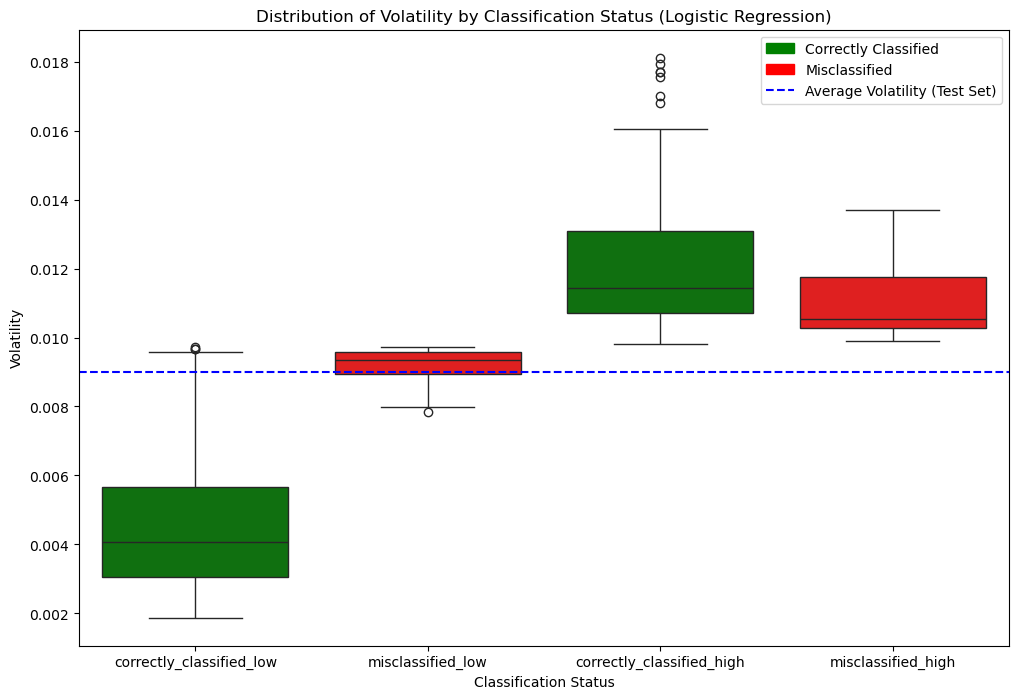

In [36]:
import matplotlib.patches as mpatches

# Add true labels and predicted labels to results_df for volatility logistic regression model
results_df_volatility = X_test_financial_metrics.copy()
results_df_volatility['true_label'] = y_test_volatility.values
results_df_volatility['predicted_label'] = y_pred_volatility

# Create a new column to indicate whether the classification was correct
results_df_volatility['correctly_classified'] = results_df_volatility['true_label'] == results_df_volatility['predicted_label']

# Create a new column to indicate the classification status
results_df_volatility['classification_status'] = results_df_volatility.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Calculate average volatility for the test set
avg_volatility_test = X_test_financial_metrics['volatility'].mean()

# Plot the box plot for volatility logistic regression model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='volatility', data=results_df_volatility, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_volatility_test, color='blue', linestyle='--', label='Average Monthly Return (Test Set)')
plt.title('Distribution of Volatility by Classification Status (Logistic Regression)')
plt.xlabel('Classification Status')
plt.ylabel('Volatility')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Volatility (Test Set)')], loc='upper right')

plt.show()

### CART

Best parameters for CART: {'max_depth': 10, 'min_samples_leaf': 17}
Accuracy of CART: 0.8785
Classification Report for CART:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       112
           1       0.89      0.88      0.89       135

    accuracy                           0.88       247
   macro avg       0.88      0.88      0.88       247
weighted avg       0.88      0.88      0.88       247



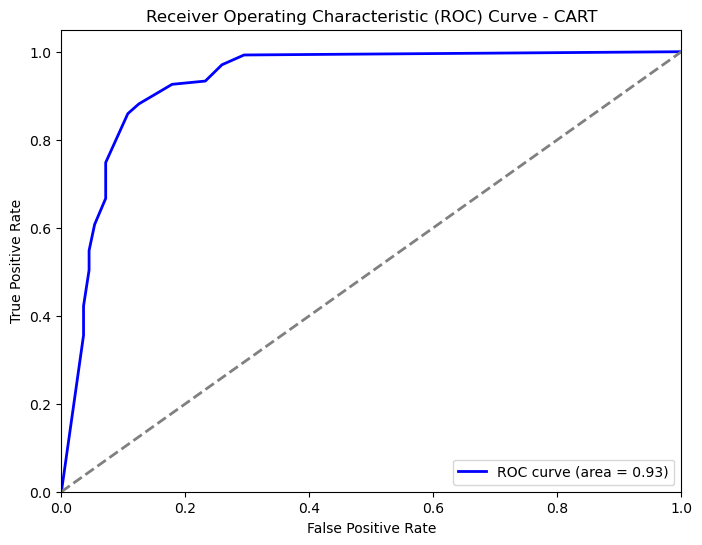

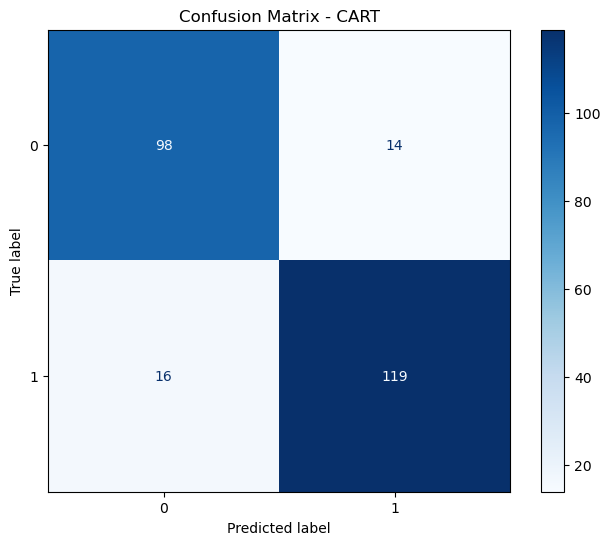

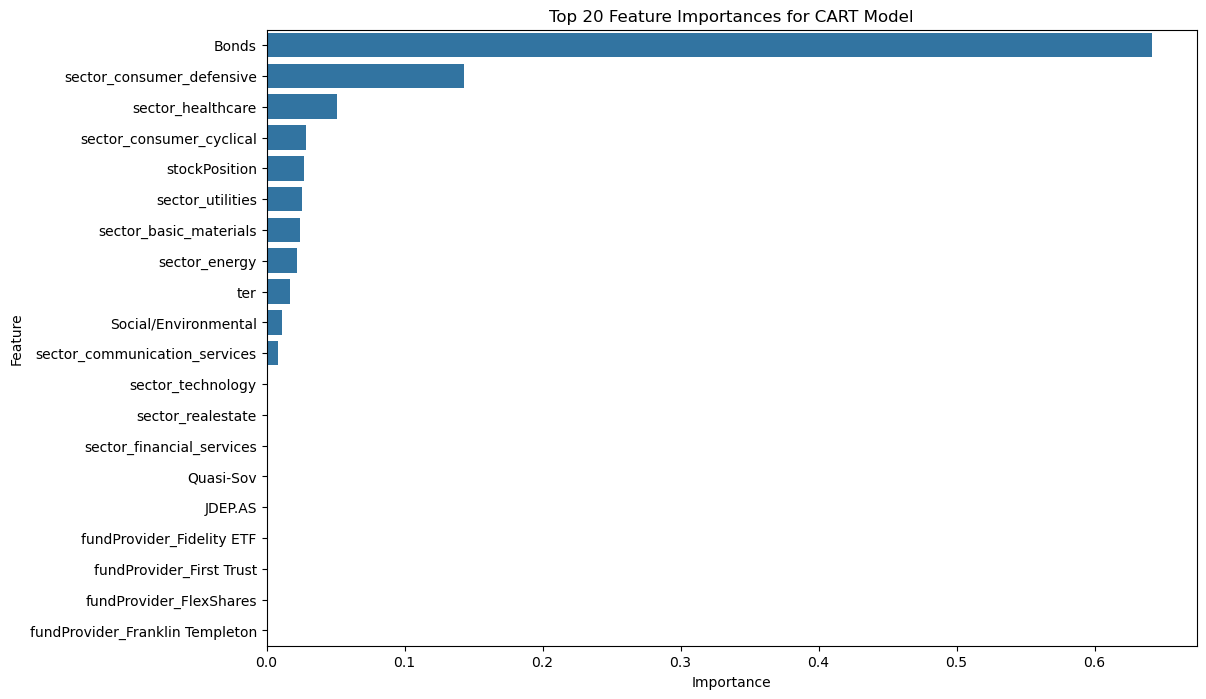

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/1963824614.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='volatility', data=results_df_cart, order=order, palette=['green', 'red', 'green', 'red'])


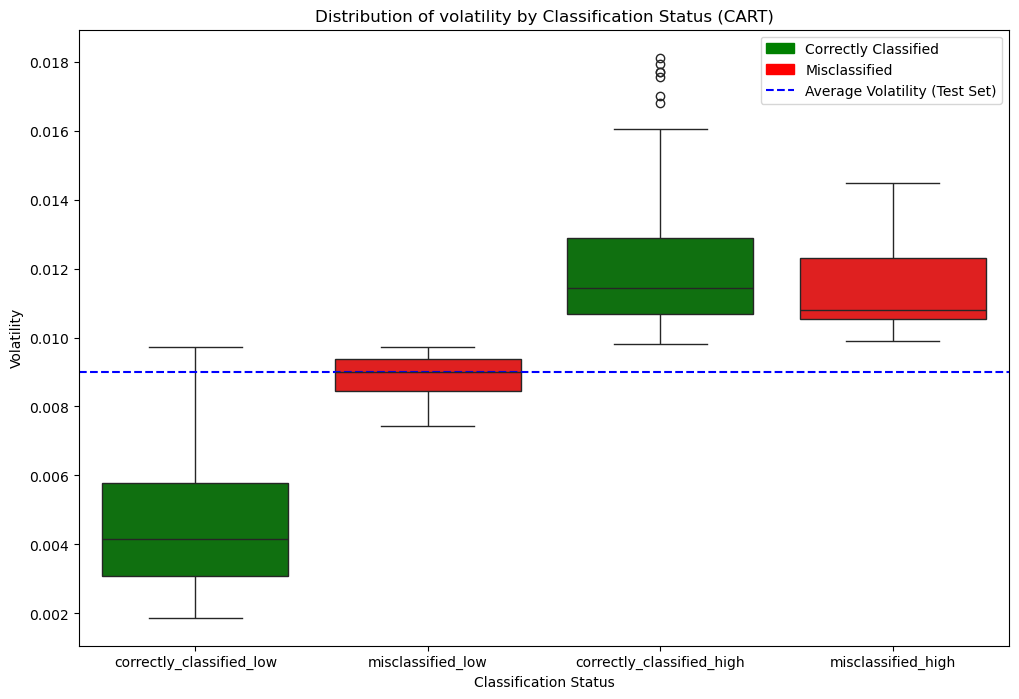

In [37]:
# Define the parameter grid for CART
param_grid_cart = {
    'max_depth': range(5, 101, 5),
    'min_samples_leaf': range(1, 21, 1)
}

# Initialize the DecisionTreeClassifier
cart_model = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for CART
grid_search_cart = GridSearchCV(cart_model, param_grid_cart, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_cart.fit(X_train, y_train_volatility)

# Get the best parameters for CART
best_params_cart = grid_search_cart.best_params_
print(f"Best parameters for CART: {best_params_cart}")

# Fit the CART model with the best parameters
best_cart_model = grid_search_cart.best_estimator_

# Predict the volatility class for the test data using CART
y_pred_cart_volatility = best_cart_model.predict(X_test)

# Evaluate the CART model
accuracy_cart_volatility = accuracy_score(y_test_volatility, y_pred_cart_volatility)
print(f"Accuracy of CART: {accuracy_cart_volatility:.4f}")
print("Classification Report for CART:")
print(classification_report(y_test_volatility, y_pred_cart_volatility))

# Plot the ROC curve for CART
fpr_cart, tpr_cart, _ = roc_curve(y_test_volatility.cat.codes, best_cart_model.predict_proba(X_test)[:, 1])
roc_auc_cart = roc_auc_score(y_test_volatility.cat.codes, best_cart_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_cart, tpr_cart, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_cart:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CART')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix for CART
cm_cart = confusion_matrix(y_test_volatility, y_pred_cart_volatility)
disp_cart = ConfusionMatrixDisplay(confusion_matrix=cm_cart, display_labels=best_cart_model.classes_)
disp_cart.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CART')
plt.show()

# Get feature importances from the best CART model
importances_cart = best_cart_model.feature_importances_

# Get the feature names
feature_names_cart = X_train.columns

# Create a DataFrame for better visualization
feature_importances_cart = pd.DataFrame({'Feature': feature_names_cart, 'Importance': importances_cart})

# Sort the DataFrame by importance
feature_importances_cart = feature_importances_cart.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_cart.head(20))
plt.title('Top 20 Feature Importances for CART Model')
plt.show()

# Add true labels and predicted labels to results_df for CART model
results_df_cart = X_test_financial_metrics.copy()
results_df_cart['true_label'] = y_test_volatility.values
results_df_cart['predicted_label'] = y_pred_cart_volatility

# Create a new column to indicate whether the classification was correct
results_df_cart['correctly_classified'] = results_df_cart['true_label'] == results_df_cart['predicted_label']

# Create a new column to indicate the classification status
results_df_cart['classification_status'] = results_df_cart.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot for CART model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='volatility', data=results_df_cart, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_volatility_test, color='blue', linestyle='--', label='Volatility (Test Set)')
plt.title('Distribution of volatility by Classification Status (CART)')
plt.xlabel('Classification Status')
plt.ylabel('Volatility')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Volatility (Test Set)')], loc='upper right')

plt.show()

### Random Forest

Best parameters for Random Forest (Volatility): {'max_depth': 20, 'n_estimators': 80}
Accuracy of Random Forest (Volatility): 0.9069
Classification Report for Random Forest (Volatility):
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       112
           1       0.91      0.93      0.92       135

    accuracy                           0.91       247
   macro avg       0.91      0.90      0.91       247
weighted avg       0.91      0.91      0.91       247



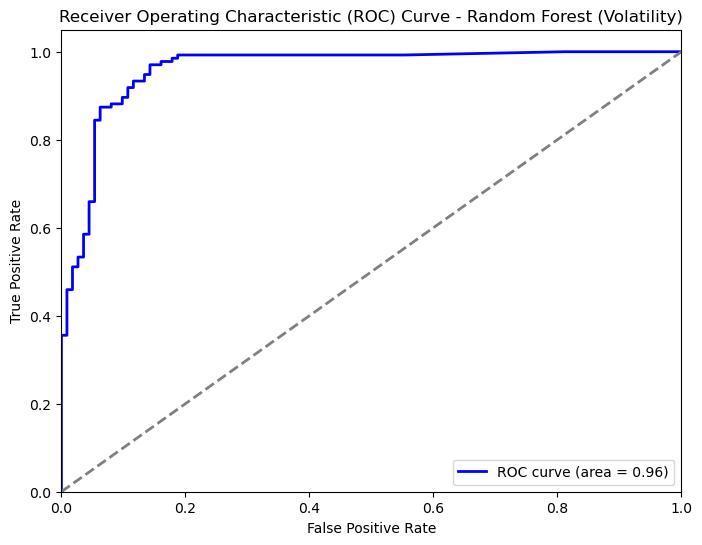

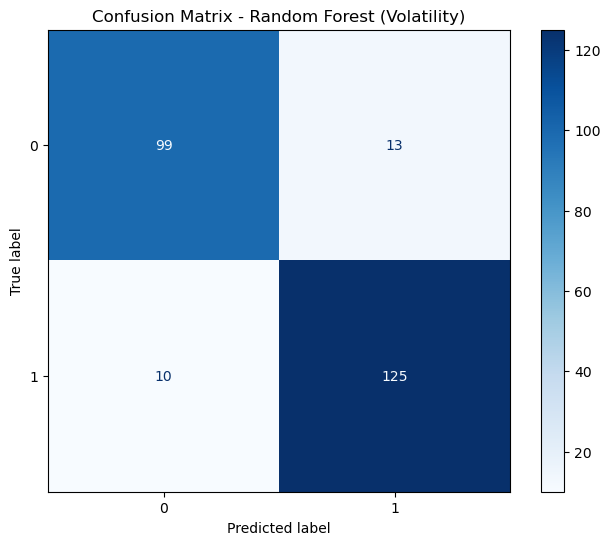

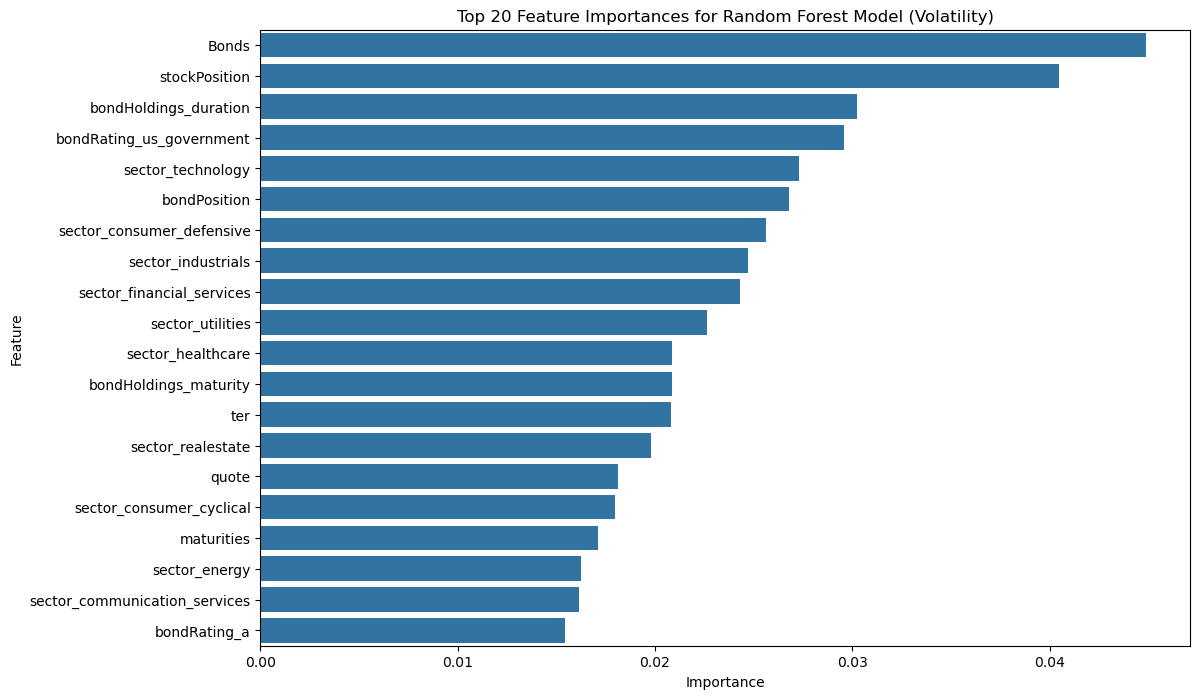

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/1452110402.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='volatility', data=results_df_rf_volatility, order=order, palette=['green', 'red', 'green', 'red'])


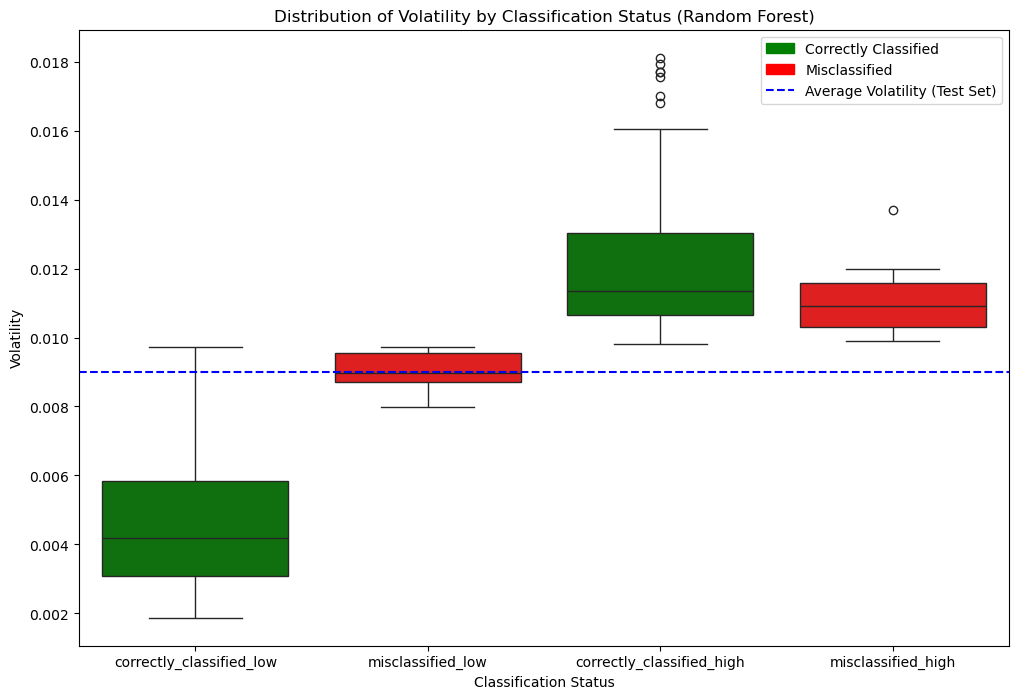

In [38]:
# Define the parameter grid for Random Forest
param_grid_rf_volatility = {
    'n_estimators': range(10, 101, 5),
    'max_depth': range(10, 101, 10)
}

# Initialize the RandomForestClassifier
rf_model_volatility = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest
grid_search_rf_volatility = GridSearchCV(rf_model_volatility, param_grid_rf_volatility, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_rf_volatility.fit(X_train, y_train_volatility)

# Get the best parameters for Random Forest
best_params_rf_volatility = grid_search_rf_volatility.best_params_
print(f"Best parameters for Random Forest (Volatility): {best_params_rf_volatility}")

# Fit the Random Forest model with the best parameters
best_rf_model_volatility = grid_search_rf_volatility.best_estimator_

# Predict the volatility class for the test data using Random Forest
y_pred_rf_volatility = best_rf_model_volatility.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf_volatility = accuracy_score(y_test_volatility, y_pred_rf_volatility)
print(f"Accuracy of Random Forest (Volatility): {accuracy_rf_volatility:.4f}")
print("Classification Report for Random Forest (Volatility):")
print(classification_report(y_test_volatility, y_pred_rf_volatility))

# Plot the ROC curve for Random Forest
fpr_rf_volatility, tpr_rf_volatility, _ = roc_curve(y_test_volatility.cat.codes, best_rf_model_volatility.predict_proba(X_test)[:, 1])
roc_auc_rf_volatility = roc_auc_score(y_test_volatility.cat.codes, best_rf_model_volatility.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_volatility, tpr_rf_volatility, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf_volatility:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest (Volatility)')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix for Random Forest
cm_rf_volatility = confusion_matrix(y_test_volatility, y_pred_rf_volatility)
disp_rf_volatility = ConfusionMatrixDisplay(confusion_matrix=cm_rf_volatility, display_labels=best_rf_model_volatility.classes_)
disp_rf_volatility.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Volatility)')
plt.show()

# Get feature importances from the best Random Forest model
importances_rf_volatility = best_rf_model_volatility.feature_importances_

# Get the feature names
feature_names_rf_volatility = X_train.columns

# Create a DataFrame for better visualization
feature_importances_rf_volatility = pd.DataFrame({'Feature': feature_names_rf_volatility, 'Importance': importances_rf_volatility})

# Sort the DataFrame by importance
feature_importances_rf_volatility = feature_importances_rf_volatility.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf_volatility.head(20))
plt.title('Top 20 Feature Importances for Random Forest Model (Volatility)')
plt.show()

# Add true labels and predicted labels to results_df for Random Forest model
results_df_rf_volatility = X_test_financial_metrics.copy()
results_df_rf_volatility['true_label'] = y_test_volatility.values
results_df_rf_volatility['predicted_label'] = y_pred_rf_volatility

# Create a new column to indicate whether the classification was correct
results_df_rf_volatility['correctly_classified'] = results_df_rf_volatility['true_label'] == results_df_rf_volatility['predicted_label']

# Create a new column to indicate the classification status
results_df_rf_volatility['classification_status'] = results_df_rf_volatility.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot for Random Forest model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='volatility', data=results_df_rf_volatility, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_volatility_test, color='blue', linestyle='--', label='Average Volatility (Test Set)')
plt.title('Distribution of Volatility by Classification Status (Random Forest)')
plt.xlabel('Classification Status')
plt.ylabel('Volatility')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Volatility (Test Set)')], loc='upper right')

plt.show()

### XGBoost

/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parame

Best parameters for XGBoost (Volatility): {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 45}
Accuracy of XGBoost (Volatility): 0.8907
Classification Report for XGBoost (Volatility):
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       112
           1       0.93      0.87      0.90       135

    accuracy                           0.89       247
   macro avg       0.89      0.89      0.89       247
weighted avg       0.89      0.89      0.89       247



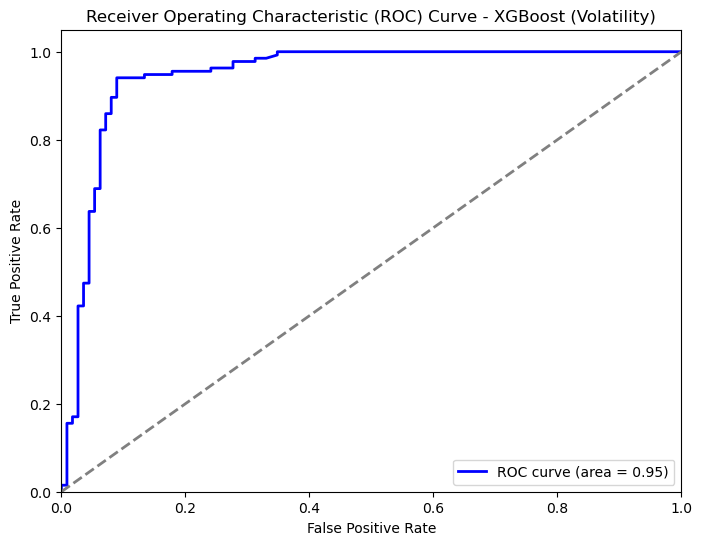

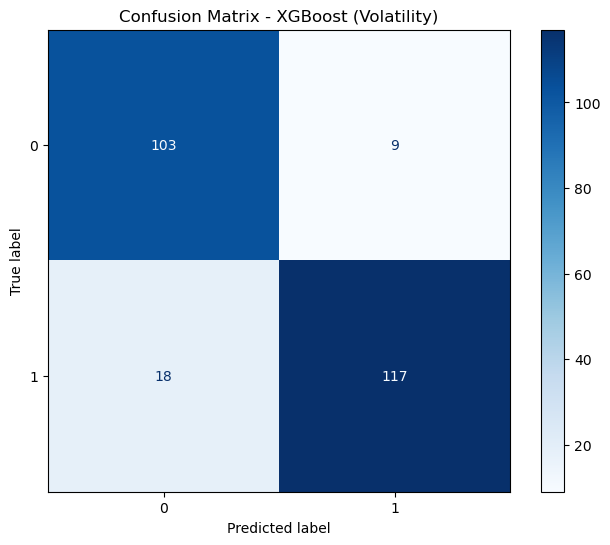

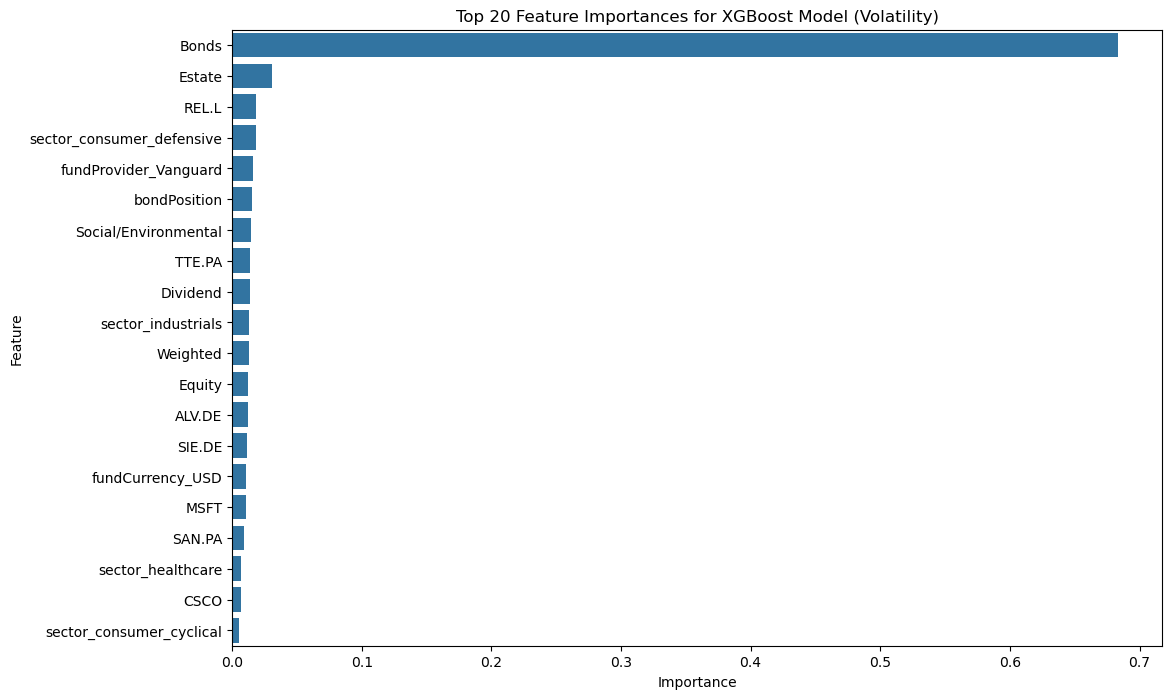

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/195289983.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='volatility', data=results_df_xgb_volatility, order=order, palette=['green', 'red', 'green', 'red'])


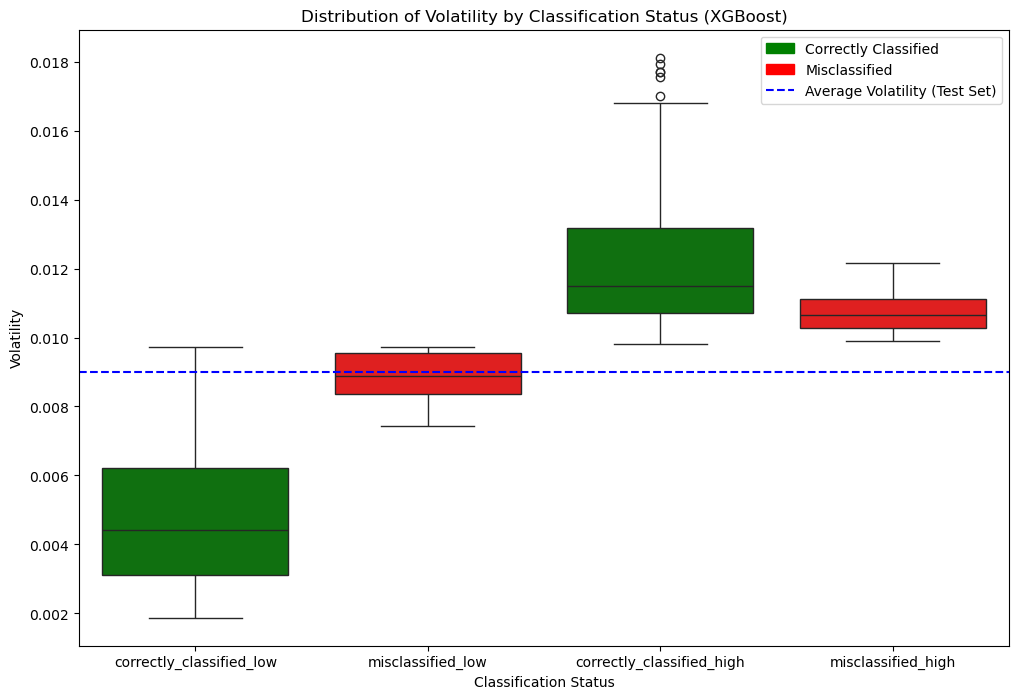

In [39]:
# Define the parameter grid for XGBoost
param_grid_xgb_volatility = {
    'max_depth': range(2, 6, 1),
    'n_estimators': range(5, 51, 5),
    'learning_rate': [1e-3, 1e-2, 1e-1, 1]
}

# Initialize the XGBClassifier
xgb_model_volatility = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV for XGBoost
grid_search_xgb_volatility = GridSearchCV(xgb_model_volatility, param_grid_xgb_volatility, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_xgb_volatility.fit(X_train, y_train_volatility)

# Get the best parameters for XGBoost
best_params_xgb_volatility = grid_search_xgb_volatility.best_params_
print(f"Best parameters for XGBoost (Volatility): {best_params_xgb_volatility}")

# Fit the XGBoost model with the best parameters
best_xgb_model_volatility = grid_search_xgb_volatility.best_estimator_

# Predict the volatility class for the test data using XGBoost
y_pred_xgb_volatility = best_xgb_model_volatility.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb_volatility = accuracy_score(y_test_volatility, y_pred_xgb_volatility)
print(f"Accuracy of XGBoost (Volatility): {accuracy_xgb_volatility:.4f}")
print("Classification Report for XGBoost (Volatility):")
print(classification_report(y_test_volatility, y_pred_xgb_volatility))

# Plot the ROC curve for XGBoost
fpr_xgb_volatility, tpr_xgb_volatility, _ = roc_curve(y_test_volatility.cat.codes, best_xgb_model_volatility.predict_proba(X_test)[:, 1])
roc_auc_xgb_volatility = roc_auc_score(y_test_volatility.cat.codes, best_xgb_model_volatility.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_volatility, tpr_xgb_volatility, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_xgb_volatility:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost (Volatility)')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix for XGBoost
cm_xgb_volatility = confusion_matrix(y_test_volatility, y_pred_xgb_volatility)
disp_xgb_volatility = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_volatility, display_labels=best_xgb_model_volatility.classes_)
disp_xgb_volatility.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost (Volatility)')
plt.show()
# Get feature importances from the best XGBoost model
importances_xgb = best_xgb_model_volatility.feature_importances_

# Get the feature names
feature_names_xgb = X_train.columns

# Create a DataFrame for better visualization
feature_importances_xgb = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})

# Sort the DataFrame by importance
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_xgb.head(20))
plt.title('Top 20 Feature Importances for XGBoost Model (Volatility)')
plt.show()

# Add true labels and predicted labels to results_df for XGBoost model
results_df_xgb_volatility = X_test_financial_metrics.copy()
results_df_xgb_volatility['true_label'] = y_test_volatility.values
results_df_xgb_volatility['predicted_label'] = y_pred_xgb_volatility

# Create a new column to indicate whether the classification was correct
results_df_xgb_volatility['correctly_classified'] = results_df_xgb_volatility['true_label'] == results_df_xgb_volatility['predicted_label']

# Create a new column to indicate the classification status
results_df_xgb_volatility['classification_status'] = results_df_xgb_volatility.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_high',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high']

# Plot the box plot for XGBoost model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='volatility', data=results_df_xgb_volatility, order=order, palette=['green', 'red', 'green', 'red'])
plt.axhline(y=avg_volatility_test, color='blue', linestyle='--', label='Average Volatility (Test Set)')
plt.title('Distribution of Volatility by Classification Status (XGBoost)')
plt.xlabel('Classification Status')
plt.ylabel('Volatility')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average Volatility (Test Set)')], loc='upper right')

plt.show()

### Model Comparison

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/2669524866.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')


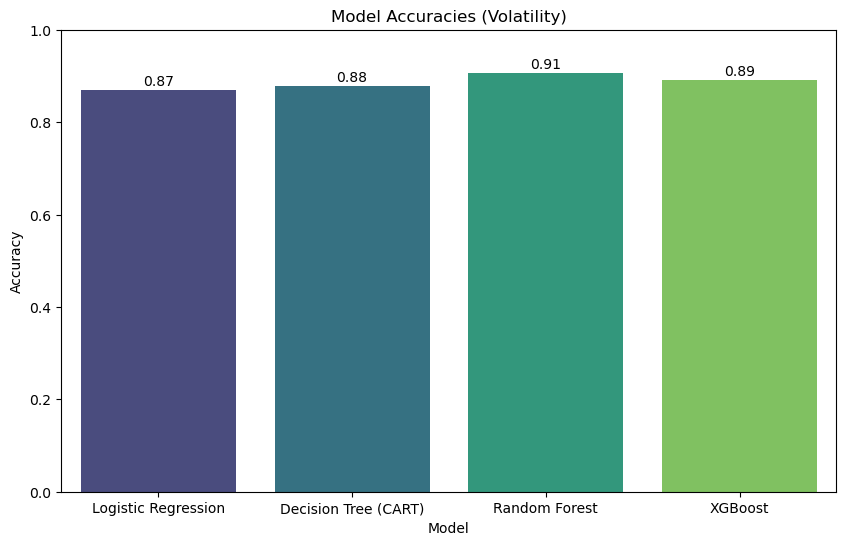

In [40]:
# Create a dictionary with model names and their accuracies
model_accuracies = {
    'Logistic Regression': accuracy_volatility,
    'Decision Tree (CART)': accuracy_cart_volatility,
    'Random Forest': accuracy_rf_volatility,
    'XGBoost': accuracy_xgb_volatility
}

# Create a DataFrame from the dictionary
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')

# Add the value of the accuracy on top of each bar
for index, row in accuracy_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", color='black', ha="center")

plt.title('Model Accuracies (Volatility)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## Predict Growth Potential

### CART

Best parameters for CART (Growth Potential): {'max_depth': 15, 'min_samples_leaf': 2}
Accuracy of CART (Growth Potential): 0.8623
Classification Report for CART (Growth Potential):
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         7
         low       0.57      0.83      0.68        30
   undefined       0.94      0.90      0.92       210

    accuracy                           0.86       247
   macro avg       0.50      0.58      0.53       247
weighted avg       0.87      0.86      0.86       247



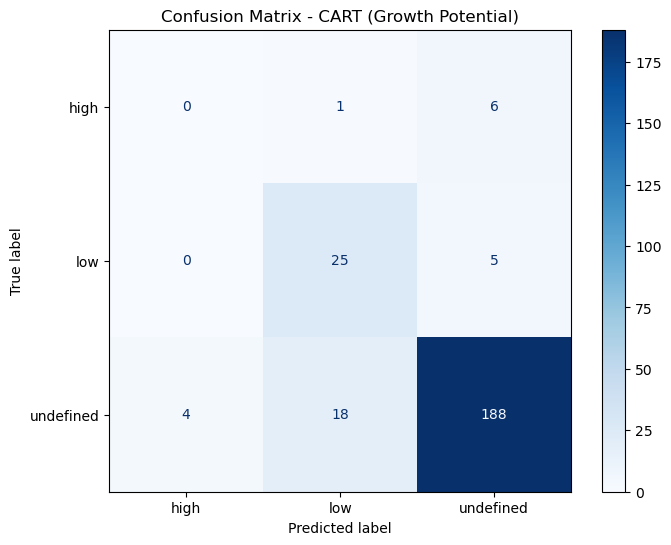

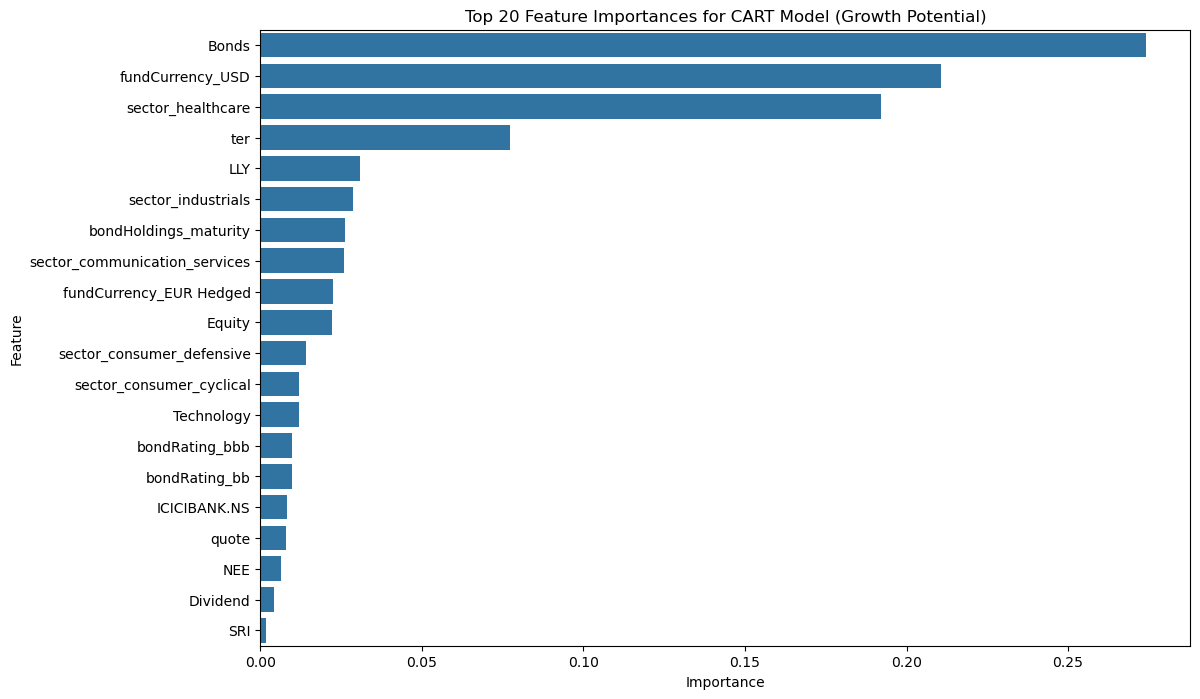

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/1457050915.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='RSI', data=results_df_cart_growth, order=order, palette=['green', 'red', 'green', 'red', 'green', 'red'])


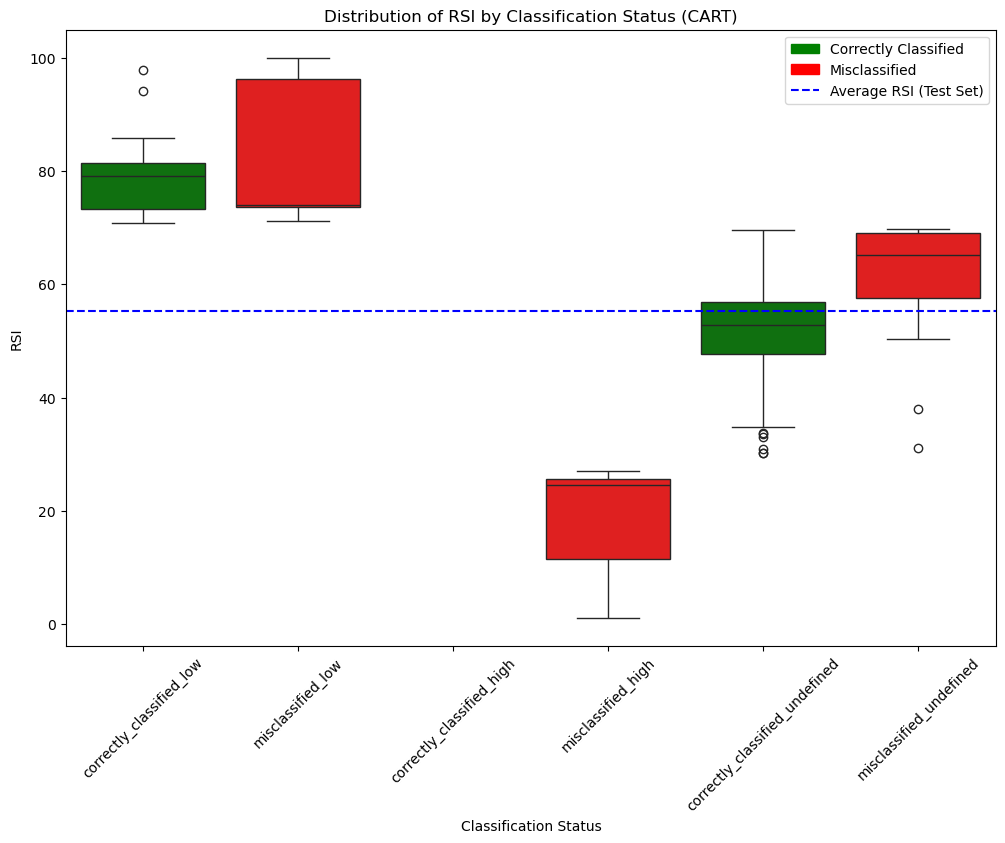

In [41]:
# Define the parameter grid for CART
param_grid_cart_growth = {
    'max_depth': range(5, 101, 5),
    'min_samples_leaf': range(1, 21, 1)
}

# Initialize the DecisionTreeClassifier
cart_model_growth = DecisionTreeClassifier(random_state=42, criterion='gini', class_weight='balanced')

# Initialize GridSearchCV for CART
grid_search_cart_growth = GridSearchCV(cart_model_growth, param_grid_cart_growth, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_cart_growth.fit(X_train, y_train_growth)

# Get the best parameters for CART
best_params_cart_growth = grid_search_cart_growth.best_params_
print(f"Best parameters for CART (Growth Potential): {best_params_cart_growth}")

# Fit the CART model with the best parameters
best_cart_model_growth = grid_search_cart_growth.best_estimator_

# Predict the growth potential class for the test data using CART
y_pred_cart_growth = best_cart_model_growth.predict(X_test)

# Evaluate the CART model
accuracy_cart_growth = accuracy_score(y_test_growth, y_pred_cart_growth)
print(f"Accuracy of CART (Growth Potential): {accuracy_cart_growth:.4f}")
print("Classification Report for CART (Growth Potential):")
print(classification_report(y_test_growth, y_pred_cart_growth))

# Plot the confusion matrix for CART
cm_cart_growth = confusion_matrix(y_test_growth, y_pred_cart_growth)
disp_cart_growth = ConfusionMatrixDisplay(confusion_matrix=cm_cart_growth, display_labels=best_cart_model_growth.classes_)
disp_cart_growth.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CART (Growth Potential)')
plt.show()

# Get feature importances from the best CART model
importances_cart_growth = best_cart_model_growth.feature_importances_

# Get the feature names
feature_names_cart_growth = X_train.columns

# Create a DataFrame for better visualization
feature_importances_cart_growth = pd.DataFrame({'Feature': feature_names_cart_growth, 'Importance': importances_cart_growth})

# Sort the DataFrame by importance
feature_importances_cart_growth = feature_importances_cart_growth.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_cart_growth.head(20))
plt.title('Top 20 Feature Importances for CART Model (Growth Potential)')
plt.show()

# Calculate average RSI for the test set
avg_rsi_test = X_test_financial_metrics['RSI'].mean()

# Add true labels and predicted labels to results_df for CART model
results_df_cart_growth = X_test_financial_metrics.copy()
results_df_cart_growth['true_label'] = y_test_growth.values
results_df_cart_growth['predicted_label'] = y_pred_cart_growth

# Create a new column to indicate whether the classification was correct
results_df_cart_growth['correctly_classified'] = results_df_cart_growth['true_label'] == results_df_cart_growth['predicted_label']

# Create a new column to indicate the classification status
results_df_cart_growth['classification_status'] = results_df_cart_growth.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 'low' and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 'low' and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 'high' and row['correctly_classified'] else
                'misclassified_high' if row['true_label'] == 'high' and not row['correctly_classified'] else
                'correctly_classified_undefined' if row['true_label'] == 'undefined' and row['correctly_classified'] else
                'misclassified_undefined',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high', 'correctly_classified_undefined', 'misclassified_undefined']

# Plot the box plot for CART model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='RSI', data=results_df_cart_growth, order=order, palette=['green', 'red', 'green', 'red', 'green', 'red'])
plt.axhline(y=avg_rsi_test, color='blue', linestyle='--', label='Average RSI (Test Set)')
plt.title('Distribution of RSI by Classification Status (CART)')
plt.xlabel('Classification Status')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.ylabel('RSI')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average RSI (Test Set)')], loc='upper right')

plt.show()

In [42]:
# Assuming the Decision Tree model is stored in the variable `best_cart_model`
possible_labels = best_cart_model_growth.classes_
print("Possible label predictions from the Decision Tree model:", possible_labels)

Possible label predictions from the Decision Tree model: ['high' 'low' 'undefined']


### Random Forest

Best parameters for Random Forest (Growth Potential): {'max_depth': 10, 'n_estimators': 90}
Accuracy of Random Forest (Growth Potential): 0.8704
Classification Report for Random Forest (Growth Potential):
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         7
         low       0.57      0.83      0.68        30
   undefined       0.95      0.90      0.92       210

    accuracy                           0.87       247
   macro avg       0.50      0.58      0.53       247
weighted avg       0.87      0.87      0.87       247



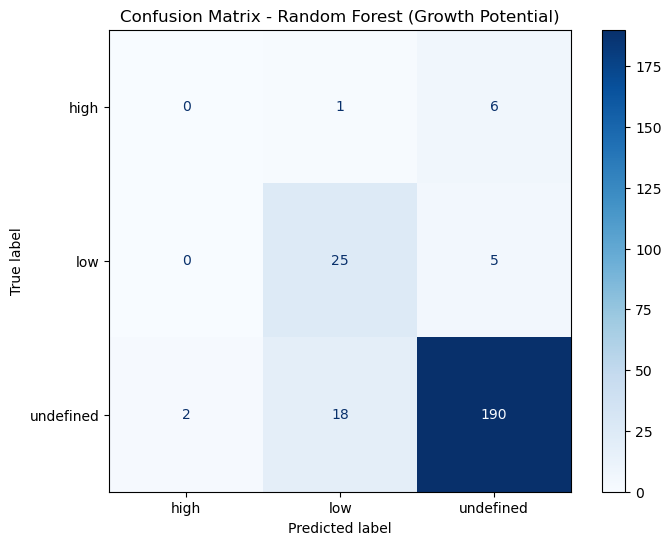

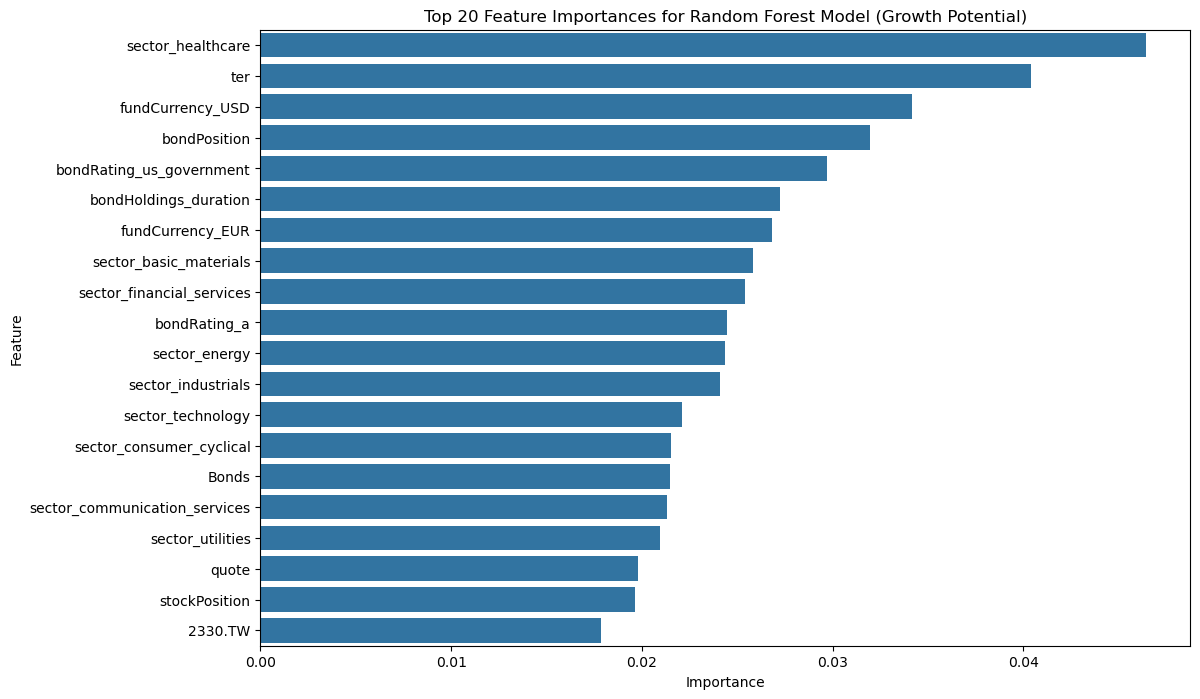

In [43]:
# Define the parameter grid for Random Forest
param_grid_rf_growth = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 101, 5),
}

# Initialize the RandomForestClassifier
rf_model_growth = RandomForestClassifier(random_state=42, class_weight='balanced')

# Initialize GridSearchCV for Random Forest
grid_search_rf_growth = GridSearchCV(rf_model_growth, param_grid_rf_growth, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_rf_growth.fit(X_train, y_train_growth)

# Get the best parameters for Random Forest
best_params_rf_growth = grid_search_rf_growth.best_params_
print(f"Best parameters for Random Forest (Growth Potential): {best_params_rf_growth}")

# Fit the Random Forest model with the best parameters
best_rf_model_growth = grid_search_rf_growth.best_estimator_

# Predict the growth potential class for the test data using Random Forest
y_pred_rf_growth = best_rf_model_growth.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf_growth = accuracy_score(y_test_growth, y_pred_rf_growth)
print(f"Accuracy of Random Forest (Growth Potential): {accuracy_rf_growth:.4f}")
print("Classification Report for Random Forest (Growth Potential):")
print(classification_report(y_test_growth, y_pred_rf_growth))

# Plot the confusion matrix for Random Forest
cm_rf_growth = confusion_matrix(y_test_growth, y_pred_rf_growth)
disp_rf_growth = ConfusionMatrixDisplay(confusion_matrix=cm_rf_growth, display_labels=best_rf_model_growth.classes_)
disp_rf_growth.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Growth Potential)')
plt.show()

# Get feature importances from the best Random Forest model
importances_rf_growth = best_rf_model_growth.feature_importances_

# Get the feature names
feature_names_rf_growth = X_train.columns

# Create a DataFrame for better visualization
feature_importances_rf_growth = pd.DataFrame({'Feature': feature_names_rf_growth, 'Importance': importances_rf_growth})

# Sort the DataFrame by importance
feature_importances_rf_growth = feature_importances_rf_growth.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf_growth.head(20))
plt.title('Top 20 Feature Importances for Random Forest Model (Growth Potential)')
plt.show()

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/3514906294.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='RSI', data=results_df_rf_growth, order=order, palette=['green', 'red', 'green', 'red', 'green', 'red'])


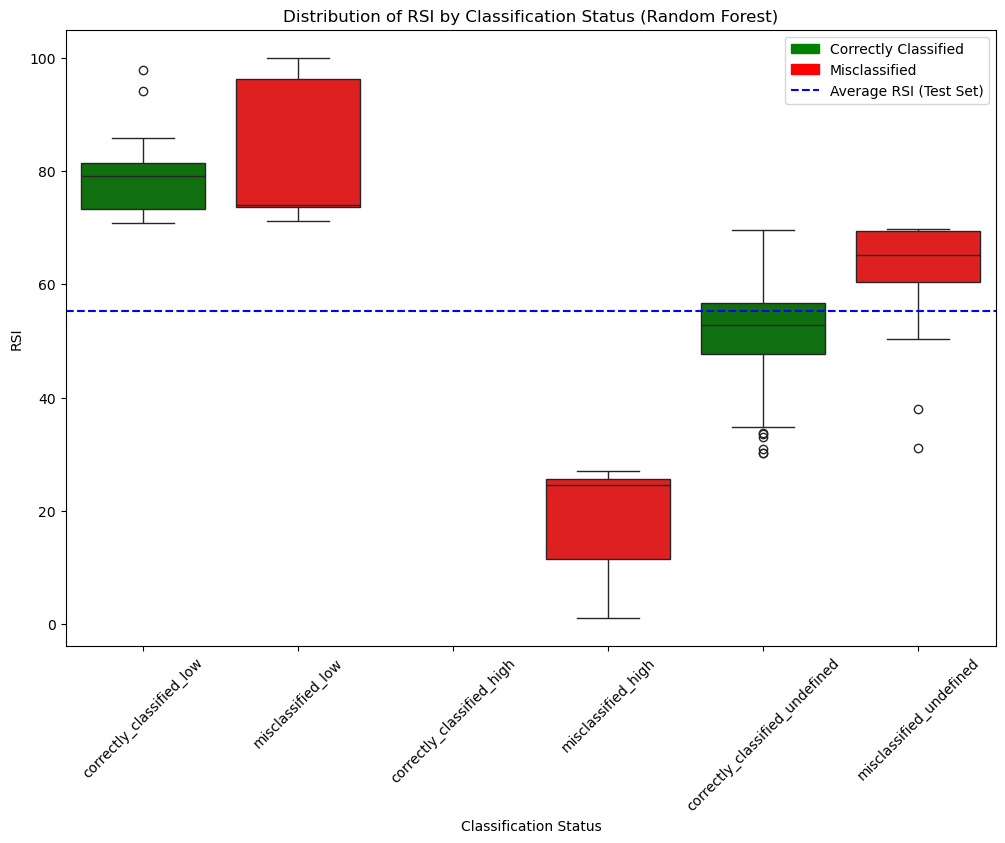

In [44]:
# Calculate average RSI for the test set
avg_rsi_test = X_test_financial_metrics['RSI'].mean()

# Add true labels and predicted labels to results_df for Random Forest model
results_df_rf_growth = X_test_financial_metrics.copy()
results_df_rf_growth['true_label'] = y_test_growth.values
results_df_rf_growth['predicted_label'] = y_pred_rf_growth

# Create a new column to indicate whether the classification was correct
results_df_rf_growth['correctly_classified'] = results_df_rf_growth['true_label'] == results_df_rf_growth['predicted_label']

# Create a new column to indicate the classification status
results_df_rf_growth['classification_status'] = results_df_rf_growth.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 'low' and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 'low' and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 'high' and row['correctly_classified'] else
                'misclassified_high' if row['true_label'] == 'high' and not row['correctly_classified'] else
                'correctly_classified_undefined' if row['true_label'] == 'undefined' and row['correctly_classified'] else
                'misclassified_undefined',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high', 'correctly_classified_undefined', 'misclassified_undefined']

# Plot the box plot for Random Forest model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='RSI', data=results_df_rf_growth, order=order, palette=['green', 'red', 'green', 'red', 'green', 'red'])
plt.axhline(y=avg_rsi_test, color='blue', linestyle='--', label='Average RSI (Test Set)')
plt.title('Distribution of RSI by Classification Status (Random Forest)')
plt.xlabel('Classification Status')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.ylabel('RSI')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average RSI (Test Set)')], loc='upper right')

plt.show()

### XGBoost

In [47]:
# Map the volatility classes to binary values
y_train_growth = y_train_growth.map({'high': 2, 'undefined': 1, 'low': 0})
y_test_growth = y_test_growth.map({'high': 2, 'undefined': 1, 'low': 0})

/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:16:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:16:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:16:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/tommasoserafin/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:16:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parame

Best parameters for XGBoost (Growth): {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 20}
Accuracy of XGBoost (Growth): 0.8826
Classification Report for XGBoost (Growth):
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        30
           1       0.93      0.94      0.93       210
           2       0.00      0.00      0.00         7

    accuracy                           0.88       247
   macro avg       0.53      0.55      0.54       247
weighted avg       0.87      0.88      0.88       247



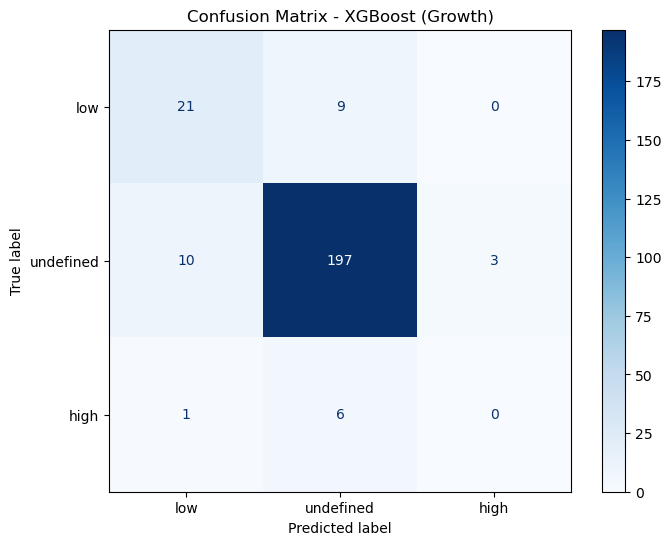

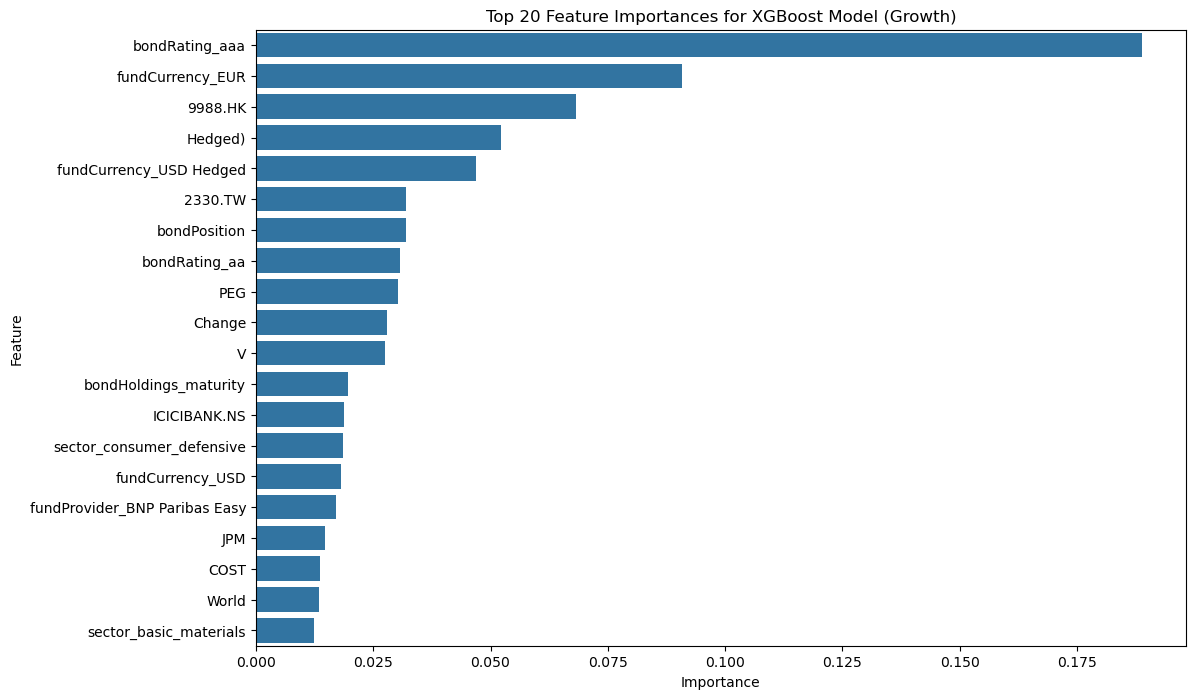

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/878447237.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification_status', y='RSI', data=results_df_xgb_growth, order=order, palette=['green', 'red', 'green', 'red', 'green', 'red'])


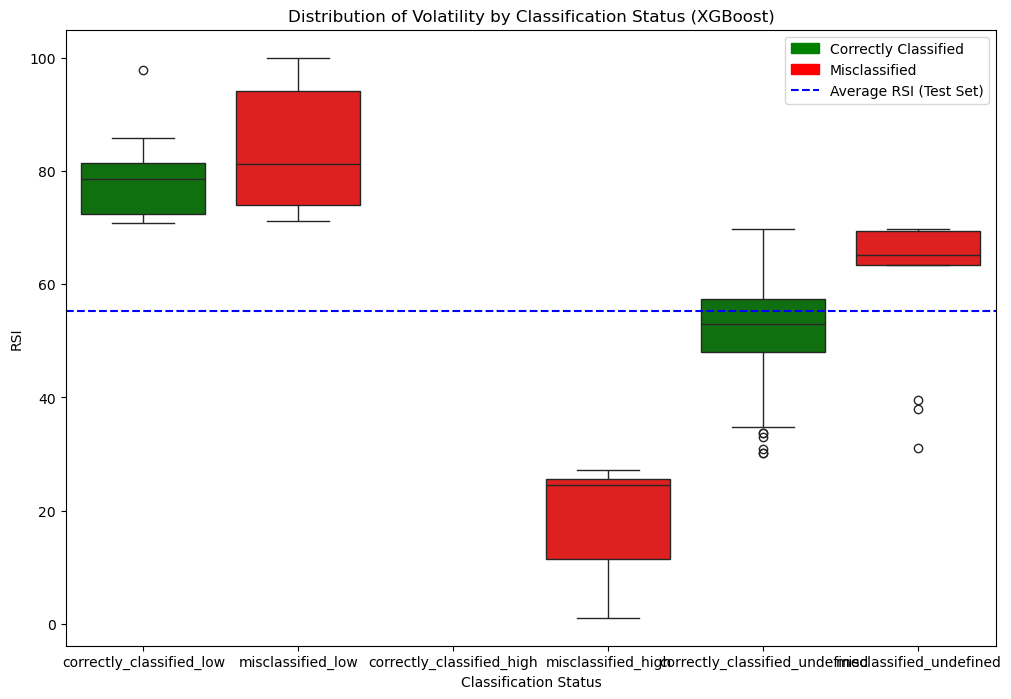

In [49]:
# Define the parameter grid for XGBoost
param_grid_xgb_growth = {
    'max_depth': range(2, 6, 1),
    'n_estimators': range(5, 51, 5),
    'learning_rate': [1e-3, 1e-2, 1e-1, 1]
}

# Initialize the XGBClassifier for multiclass classification
xgb_model_growth = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='mlogloss', objective='multi:softmax', num_class=3)

# Initialize GridSearchCV for XGBoost
grid_search_xgb_growth = GridSearchCV(xgb_model_growth, param_grid_xgb_growth, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_xgb_growth.fit(X_train, y_train_growth)

# Get the best parameters for XGBoost
best_params_xgb_growth = grid_search_xgb_growth.best_params_
print(f"Best parameters for XGBoost (Growth): {best_params_xgb_growth}")

# Fit the XGBoost model with the best parameters
best_xgb_model_growth = grid_search_xgb_growth.best_estimator_

# Predict the growth potential class for the test data using XGBoost
y_pred_xgb_growth = best_xgb_model_growth.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb_growth = accuracy_score(y_test_growth, y_pred_xgb_growth)
print(f"Accuracy of XGBoost (Growth): {accuracy_xgb_growth:.4f}")
print("Classification Report for XGBoost (Growth):")
print(classification_report(y_test_growth, y_pred_xgb_growth))

# Plot the confusion matrix for XGBoost
cm_xgb_growth = confusion_matrix(y_test_growth, y_pred_xgb_growth)
disp_xgb_growth = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_growth, display_labels=['low', 'undefined', 'high'])
disp_xgb_growth.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost (Growth)')
plt.show()

# Get feature importances from the best XGBoost model
importances_xgb_growth = best_xgb_model_growth.feature_importances_

# Get the feature names
feature_names_xgb_growth = X_train.columns

# Create a DataFrame for better visualization
feature_importances_xgb_growth = pd.DataFrame({'Feature': feature_names_xgb_growth, 'Importance': importances_xgb_growth})

# Sort the DataFrame by importance
feature_importances_xgb_growth = feature_importances_xgb_growth.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_xgb_growth.head(20))
plt.title('Top 20 Feature Importances for XGBoost Model (Growth)')
plt.show()

# Add true labels and predicted labels to results_df for XGBoost model
results_df_xgb_growth = X_test_financial_metrics.copy()
results_df_xgb_growth['true_label'] = y_test_growth.values
results_df_xgb_growth['predicted_label'] = y_pred_xgb_growth

# Create a new column to indicate whether the classification was correct
results_df_xgb_growth['correctly_classified'] = results_df_xgb_growth['true_label'] == results_df_xgb_growth['predicted_label']

# Create a new column to indicate the classification status
results_df_xgb_growth['classification_status'] = results_df_xgb_growth.apply(
    lambda row: 'correctly_classified_low' if row['true_label'] == 0 and row['correctly_classified'] else
                'misclassified_low' if row['true_label'] == 0 and not row['correctly_classified'] else
                'correctly_classified_high' if row['true_label'] == 2 and row['correctly_classified'] else
                'misclassified_high' if row['true_label'] == 2 and not row['correctly_classified'] else
                'correctly_classified_undefined' if row['true_label'] == 1 and row['correctly_classified'] else
                'misclassified_undefined',
    axis=1
)

# Define the order of the categories
order = ['correctly_classified_low', 'misclassified_low', 'correctly_classified_high', 'misclassified_high', 'correctly_classified_undefined', 'misclassified_undefined']

# Plot the box plot for XGBoost model
plt.figure(figsize=(12, 8))
sns.boxplot(x='classification_status', y='RSI', data=results_df_xgb_growth, order=order, palette=['green', 'red', 'green', 'red', 'green', 'red'])
plt.axhline(y=avg_rsi_test, color='blue', linestyle='--', label='Average RSI (Test Set)')
plt.title('Distribution of Volatility by Classification Status (XGBoost)')
plt.xlabel('Classification Status')
plt.ylabel('RSI')

# Create custom legend handles
correctly_classified_patch = mpatches.Patch(color='green', label='Correctly Classified')
misclassified_patch = mpatches.Patch(color='red', label='Misclassified')

# Add the legend to the plot
plt.legend(handles=[correctly_classified_patch, misclassified_patch, plt.Line2D([0], [0], color='blue', linestyle='--', label='Average RSI (Test Set)')], loc='upper right')

plt.show()

### Model Comparison

/var/folders/kp/xf69b9fn4zjgxth11pf38bd40000gn/T/ipykernel_37344/2193456101.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')


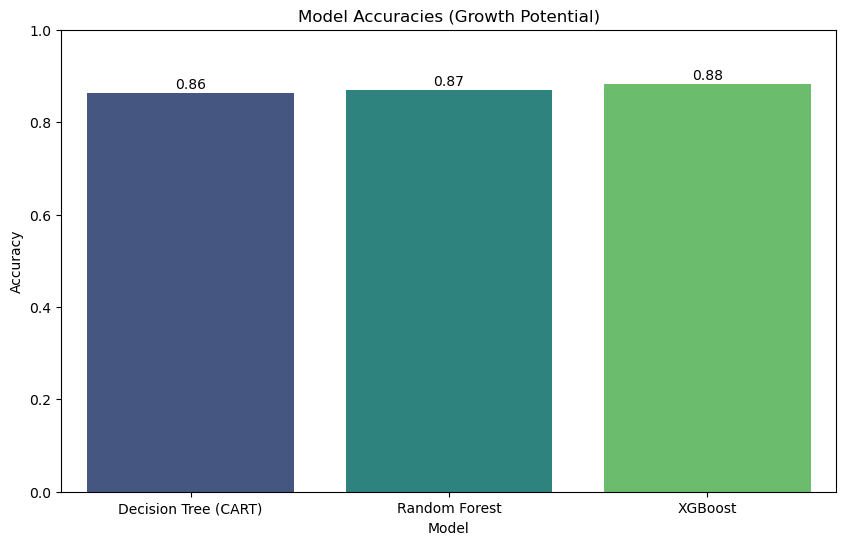

In [51]:
# Create a dictionary with model names and their accuracies
model_accuracies = {
    'Decision Tree (CART)': accuracy_cart_growth,
    'Random Forest': accuracy_rf_growth,
    'XGBoost': accuracy_xgb_growth
}

# Create a DataFrame from the dictionary
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')

# Add the value of the accuracy on top of each bar
for index, row in accuracy_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", color='black', ha="center")

plt.title('Model Accuracies (Growth Potential)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

### Model Comparison Combined

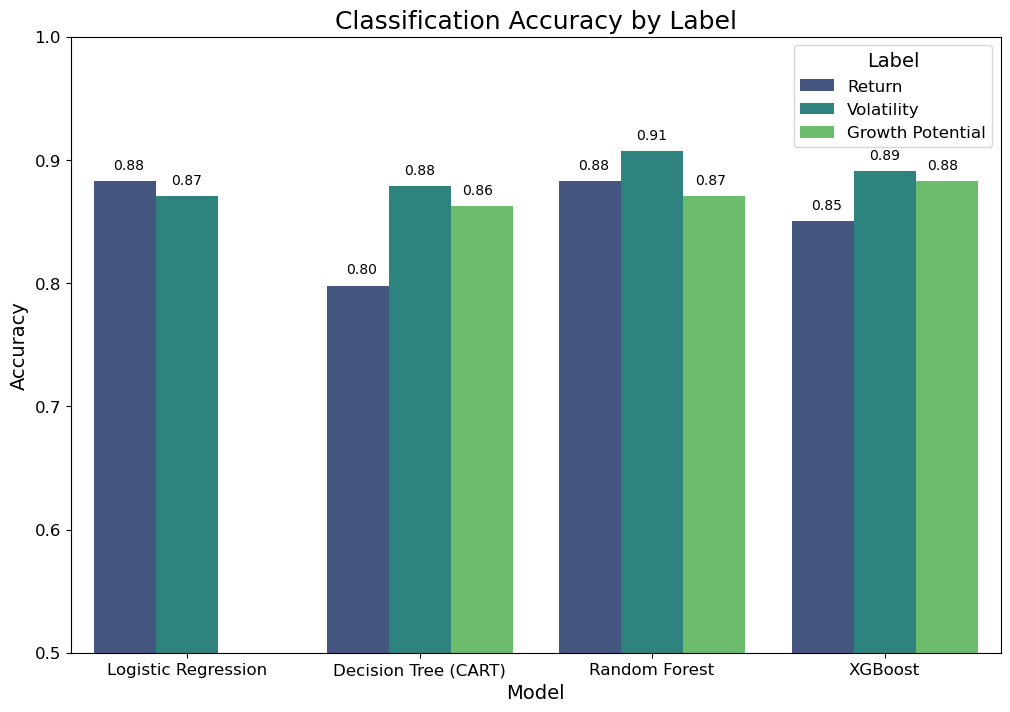

In [62]:
# Define accuracies for each metric
accuracies = {
    'Model': ['Logistic Regression', 'Decision Tree (CART)', 'Random Forest', 'XGBoost'],
    'Return': [accuracy, accuracy_cart, accuracy_rf, accuracy_xgb],  # Replace with actual return accuracies
    'Volatility': [accuracy_volatility, accuracy_cart_volatility, accuracy_rf_volatility, accuracy_xgb_volatility],  # Replace with actual volatility accuracies
    'Growth Potential': [0, accuracy_cart_growth, accuracy_rf_growth, accuracy_xgb_growth]  # Replace with actual growth accuracies
}

# Convert dictionary into a DataFrame for grouped plotting
accuracy_df = pd.DataFrame(accuracies)

# Melt the DataFrame to long format for grouped barplot
accuracy_long = pd.melt(accuracy_df, id_vars='Model', var_name='Metric', value_name='Accuracy')

# Plot grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', hue='Metric', data=accuracy_long, palette='viridis')

# Add value annotations
for index, row in accuracy_long.iterrows():
    if row['Accuracy'] == 0:
        continue
    plt.text(
        x=index % 4 - 0.25 + ['Return', 'Volatility', 'Growth Potential'].index(row['Metric']) * 0.25,
        y=row['Accuracy'] + 0.01,
        s=f"{row['Accuracy']:.2f}",
        ha="center",
        fontsize=10
    )

# Enhance the plot
plt.title('Classification Accuracy by Label', fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.5, 1)
plt.legend(title='Label', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()
